In [53]:
import time
import warnings
import numpy as np
import pandas as pd

# Start measuring time
start_time = time.time()

# Import the 'warnings' module to handle warning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import the 'numpy' and 'pandas' libraries

# Set the precision option for pandas to display up to 3 decimal places
# pd.set_option('precision', 3)

# Your machine learning code here
# For example:
# model.fit(X_train, y_train)

# End measuring time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")


Runtime: 0.0 seconds


In [54]:
# Data Visualisation Libraries
import matplotlib.pyplot as plt
# Set the figure format for better quality in inline plots (for Jupyter notebooks)
%config InlineBackend.figure_format = 'retina'

# Install or upgrade the 'seaborn' library for statistical data visualization
!pip install seaborn --upgrade
import seaborn as sns
# Set the style for seaborn plots to 'darkgrid' for a dark background with grid lines
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler



import time

start_time = time.time()

# Data Visualisation Libraries
import matplotlib.pyplot as plt
# Set the figure format for better quality in inline plots (for Jupyter notebooks)
%config InlineBackend.figure_format = 'retina'

# Install or upgrade the 'seaborn' library for statistical data visualization
!pip install seaborn --upgrade
import seaborn as sns
# Set the style for seaborn plots to 'darkgrid' for a dark background with grid lines
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")




Execution time: 9.288884401321411 seconds


In [55]:
# Import various classifiers for machine learning
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import various evaluation metrics for machine learning
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# Print a message to indicate that all libraries have been imported successfully
print('✔️ Libraries Imported!')







import time

start_time = time.time()
# Import various classifiers for machine learning
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import various evaluation metrics for machine learning
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# Print a message to indicate that all libraries have been imported successfully
print('✔️ Libraries Imported!')


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


✔️ Libraries Imported!
✔️ Libraries Imported!
Execution time: 0.0 seconds


In [56]:
df = pd.read_csv('Churn_Modelling.csv')

start_time = time.time()

df = pd.read_csv('Churn_Modelling.csv')
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 0.0332796573638916 seconds


In [57]:
start_time = time.time()

print('The given dataset has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")





The given dataset has 10000 rows and 14 columns.
Execution time: 0.0 seconds


In [58]:
# font_size = 20
# plt.rcParams['axes.labelsize'] = font_size
# plt.rcParams['axes.titlesize'] = font_size + 2
# plt.rcParams['xtick.labelsize'] = font_size - 2
# plt.rcParams['ytick.labelsize'] = font_size - 2
# plt.rcParams['legend.fontsize'] = font_size - 2

# colors = ['#00A5E0', '#DD403A']
# colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
# colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

# random_state = 42
# scoring_metric = 'recall'
# comparison_dict, comparison_test_dict = {}, {}

# print('✔️ Default Parameters and Variables Set!')


# df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
# df.columns

In [59]:
start_time = time.time()

def plot_continuous(feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    # Create a copy of the training dataframe to work with inside the function
    df_func = train_df.copy()

    # Convert the 'Exited' column to a categorical variable to use it in the boxplot later
    df_func['Exited'] = df_func['Exited'].astype('category')

    # Create a figure with two subplots: one for histogram and one for boxplot
    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    # Loop through 'df_retained' and 'df_churned' dataframes to plot histograms for both categories
    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,  # Set kde=False to display a regular histogram without KDE curve
                     ax=ax1)
    ax1.legend()  # Show legend in the first subplot

    # Create a boxplot showing the distribution of the specified feature for 'Retained' and 'Churned' categories
    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')  # Remove y-axis label in the second subplot
    ax2.set_yticklabels(['Retained', 'Churned'])  # Rename y-axis ticks to 'Retained' and 'Churned'

    plt.tight_layout()  # Adjust the layout of the subplots for better spacing

print('✔️ Function Defined!')

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

✔️ Function Defined!
Execution time: 0.0 seconds


In [60]:
# def plot_categorical(feature):
#     '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
#     # Create a figure with two subplots side by side
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#     # Plot the count of each category based on 'Exited' (Churned/Retained) using a countplot
#     sns.countplot(x=feature,
#                   hue='Exited',  # Separate count by 'Exited' (Churned/Retained) using different colors
#                   data=train_df,
#                   palette=colors,
#                   ax=ax1)
#     ax1.set_ylabel('Count')  # Set y-axis label for the first subplot
#     ax1.legend(labels=['Retained', 'Churned'])  # Set legend labels for the first subplot

#     # Plot the churn rate for each category based on 'Exited' using a barplot
#     sns.barplot(x=feature,
#                 y='Exited',  # Y-axis represents the churn rate
#                 data=train_df,
#                 palette=colors_cat,
#                 ax=ax2)
#     ax2.set_ylabel('Churn rate')  # Set y-axis label for the second subplot

#     # If the categorical feature is 'HasCrCard' or 'IsActiveMember', rename x-axis tick labels to 'No' and 'Yes'
#     if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
#         ax1.set_xticklabels(['No', 'Yes'])
#         ax2.set_xticklabels(['No', 'Yes'])

#     plt.tight_layout()  # Adjust the layout of the subplots for better spacing

# print('✔️ Function Defined!')


In [61]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

print('✔️ Default Parameters and Variables Set!')

✔️ Default Parameters and Variables Set!


In [62]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(data=cm,
                annot=True,  # Show the numerical values inside each cell
                cmap='Blues',  # Set the color map for the heatmap
                annot_kws={'fontsize': 30},  # Set font size for annotations
                ax=ax)  # Use the specified axes object to plot the heatmap

    # Set the x-axis label and tick labels for predicted labels
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])  # Set the positions of x-axis tick marks
    ax.set_xticklabels(['Retained', 'Churned'])  # Set the labels for x-axis tick marks

    # Set the y-axis label and tick labels for true labels
    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])  # Set the positions of y-axis tick marks
    ax.set_yticklabels(['Retained', 'Churned'])  # Set the labels for y-axis tick marks

print('✔️ Function Defined!')


✔️ Function Defined!


In [63]:
def plot_learning_curve(estimator, X, y, ax, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    # Compute the learning curve using the given estimator, input data (X, y), and other parameters
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,  # Number of cross-validation folds (None for default 5-fold)
        n_jobs=-1,  # Use all available CPU cores for parallel processing
        train_sizes=train_sizes,  # Proportions of the training data used for learning curve
        scoring='accuracy'  # Evaluation metric used for scoring (accuracy in this case)
    )

    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Fill the area between the mean training scores minus/plus one standard deviation
    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,  # Set the transparency of the filled area
                    color='dodgerblue')  # Set the color for the filled area

    # Fill the area between the mean test scores minus/plus one standard deviation
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,  # Set the transparency of the filled area
                    color='darkorange')  # Set the color for the filled area

    # Plot the mean training scores with markers and a solid line
    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')  # Label for the training score plot

    # Plot the mean test scores with markers and a solid line
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')  # Label for the cross-validation score plot

    # Set the x-axis label, y-axis label, and legend location
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14)  # Show the legend in the best location with font size 14

print('✔️ Function Defined!')


✔️ Function Defined!


In [64]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    # Print the classifier name for identification
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))  # Display the best score obtained by the classifier during hyperparameter tuning
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():  # Loop through the best hyperparameters and print them
        print('      {}: {}'.format(key, value))

    # Generate predicted probabilities using cross-validation
    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,  # Number of cross-validation folds
                                  method='predict_proba')[:, 1]  # Get the predicted probabilities for the positive class

    # Convert predicted probabilities to binary predictions using a threshold of 0.5
    y_pred = y_pred_pp.round()

    # Compute the confusion matrix for the binary predictions
    cm = confusion_matrix(y_train, y_pred, normalize='true')  # Normalize the confusion matrix for better interpretation

    # Compute the ROC curve to get false positive rate (fpr) and true positive rate (tpr)
    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)

    # Store classifier performance metrics in the comparison dictionary for later comparison
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp),
        fpr,
        tpr
    ]

    # Create a figure with two subplots side by side for confusion matrix and learning curve plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the confusion matrix in the first subplot
    plot_conf_mx(cm, ax1)

    # Plot the learning curve in the second subplot
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout()  # Adjust the layout of the subplots for better spacing

print('✔️ Function Defined!')


✔️ Function Defined!


In [65]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    # Extract feature importances from the classifier's best estimator
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    # Sort the features based on importance in ascending order and set the feature column as the index
    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    # Plot the feature importances as a horizontal bar plot
    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,  # Hide the legend since it's not needed for a single plot
                          ax=ax)  # Use the specified axes object for the plot

    # Set the title and x-axis label for the plot
    ax.set_title(classifier_name)  # Set the plot title to the classifier's name
    ax.set_xlabel('Importance')  # Set the label for the x-axis to 'Importance'

print('✔️ Function Defined!')


✔️ Function Defined!


In [66]:
def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    # Predict on the test set using the classifier
    y_pred = classifier.predict(X_test)

    # Compute the confusion matrix for the test predictions
    cm = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize the confusion matrix for better interpretation

    # Store classifier performance metrics on the test set in the comparison_test_dict for later comparison
    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    # Plot the confusion matrix using a heatmap
    sns.heatmap(cm,
                annot=True,  # Show the numerical values inside each cell
                annot_kws={'fontsize': 24},  # Set font size for annotations
                cmap='Blues',  # Set the color map for the heatmap
                ax=ax)  # Use the specified axes object for the plot

    # Set the title for the plot
    ax.set_title(classifier_name)  # Set the plot title to the classifier's name

    # Set the x-axis label and tick labels for predicted labels
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])  # Set the positions of x-axis tick marks
    ax.set_xticklabels(['Retained', 'Churned'])  # Set the labels for x-axis tick marks

    # Set the y-axis label and tick labels for true labels
    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])  # Set the positions of y-axis tick marks
    ax.set_yticklabels(['Retained', 'Churned'])  # Set the labels for y-axis tick marks

print('✔️ Function Defined!')


✔️ Function Defined!


In [67]:
def plot_categorical(feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    # Create a figure with two subplots side by side for countplot and barplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the count of each category based on 'Exited' (Churned/Retained) using a countplot
    sns.countplot(x=feature, hue='Exited', data=train_df, palette=colors, ax=ax1)
    ax1.set_ylabel('Count')  # Set the y-axis label for the countplot
    ax1.legend(labels=['Retained', 'Churned'])  # Set the legend labels for the countplot

    # Plot the churn rate for each category based on 'Exited' using a barplot
    sns.barplot(x=feature, y='Exited', data=train_df, palette=colors_cat, ax=ax2)
    ax2.set_ylabel('Churn rate')  # Set the y-axis label for the barplot

    # If the categorical feature is 'HasCrCard' or 'IsActiveMember', rename x-axis tick labels to 'No' and 'Yes'
    if feature in ['HasCrCard', 'IsActiveMember']:
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout()  # Adjust the layout of the subplots for better spacing

print('✔️ Function Defined!')


✔️ Function Defined!


In [68]:
df = pd.read_csv('Churn_Modelling.csv')

print('✔️ Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

✔️ Dataset Imported Successfully!

It contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [69]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [70]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [71]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [72]:
# Import the required library to split the data into training and test sets
from sklearn.model_selection import train_test_split

# Split the original DataFrame 'df' into two DataFrames: 'train_df' and 'test_df'
# The 'test_size=0.2' parameter specifies that 20% of the data will be used for the test set
# The 'random_state=random_state' parameter ensures reproducibility of the split
train_df, test_df = train_test_split(df, test_size=0.2)

# Reset the indices of the new DataFrames to avoid any inconsistencies
# The 'drop=True' parameter prevents the old index from being added as a new column
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Display the size of the training set (number of rows and columns)
print('Train set: {} rows x {} columns'.format(train_df.shape[0], train_df.shape[1]))

# Display the size of the test set (number of rows and columns)
print(' Test set: {} rows x {} columns'.format(test_df.shape[0], test_df.shape[1]))


Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


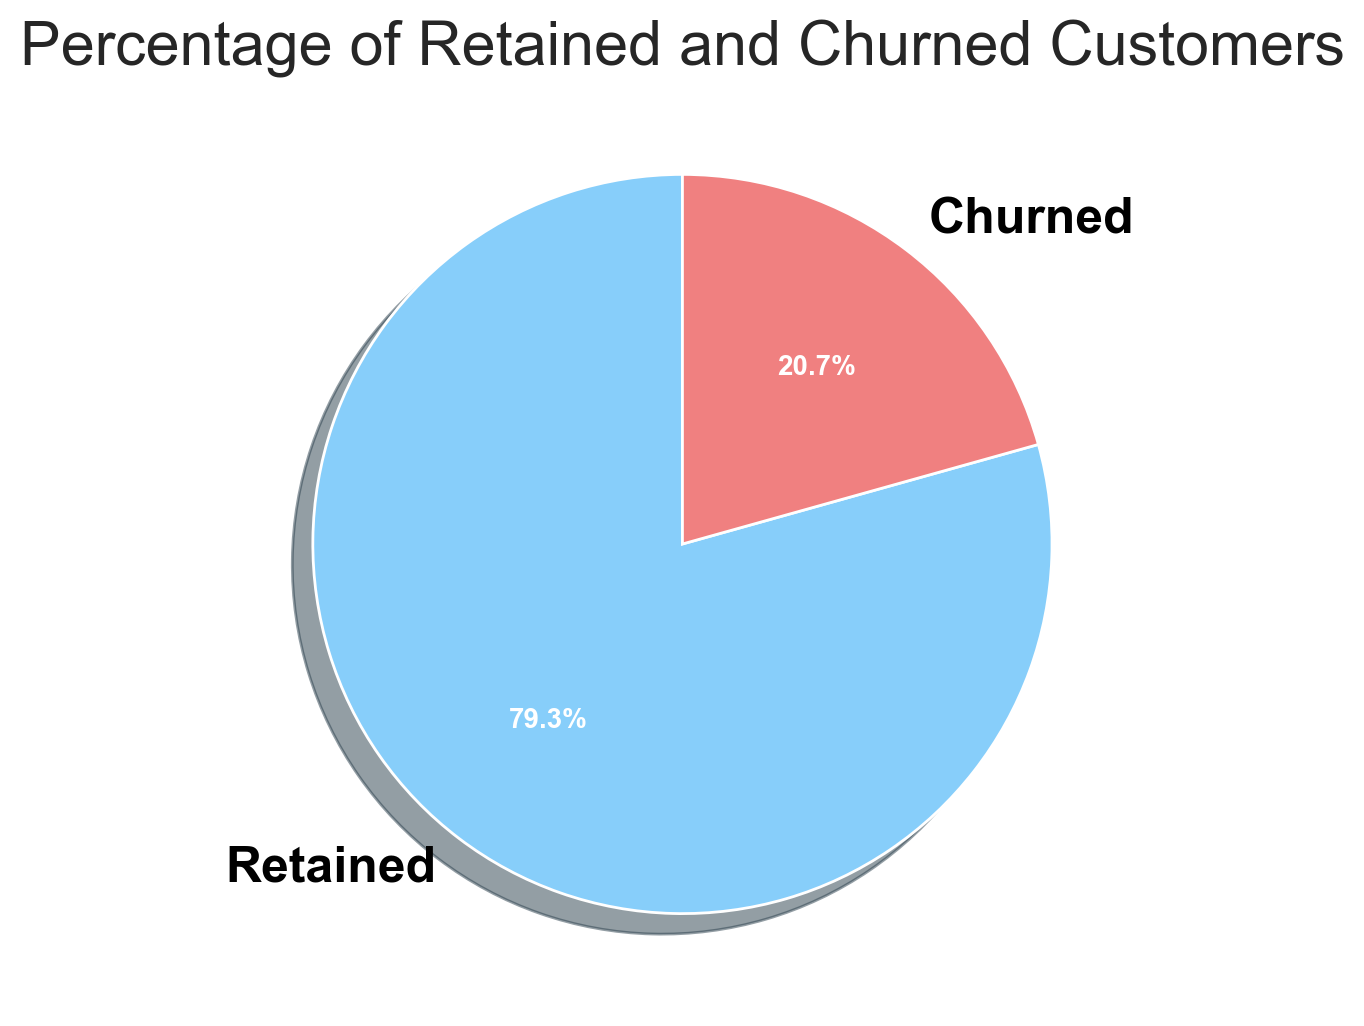

In [73]:
import matplotlib.pyplot as plt

# Calculate the percentage of each category in the 'Exited' column
exited_counts = train_df['Exited'].value_counts()
percentages = [round((count / train_df['Exited'].shape[0]) * 100, 2) for count in exited_counts]

# Create the pie chart
fig, ax = plt.subplots(figsize=(6, 6))
colors = ['lightskyblue', 'lightcoral']
wedges, texts, autotexts = ax.pie(percentages, labels=['Retained', 'Churned'], colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)

# Add percentage labels inside the pie chart
for text, autotext in zip(texts, autotexts):
    text.set(color='black', fontweight='bold')
    autotext.set(color='white', fontweight='bold')

# Set the title
ax.set_title('Percentage of Retained and Churned Customers')

# Show the pie chart
plt.show()


In [74]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


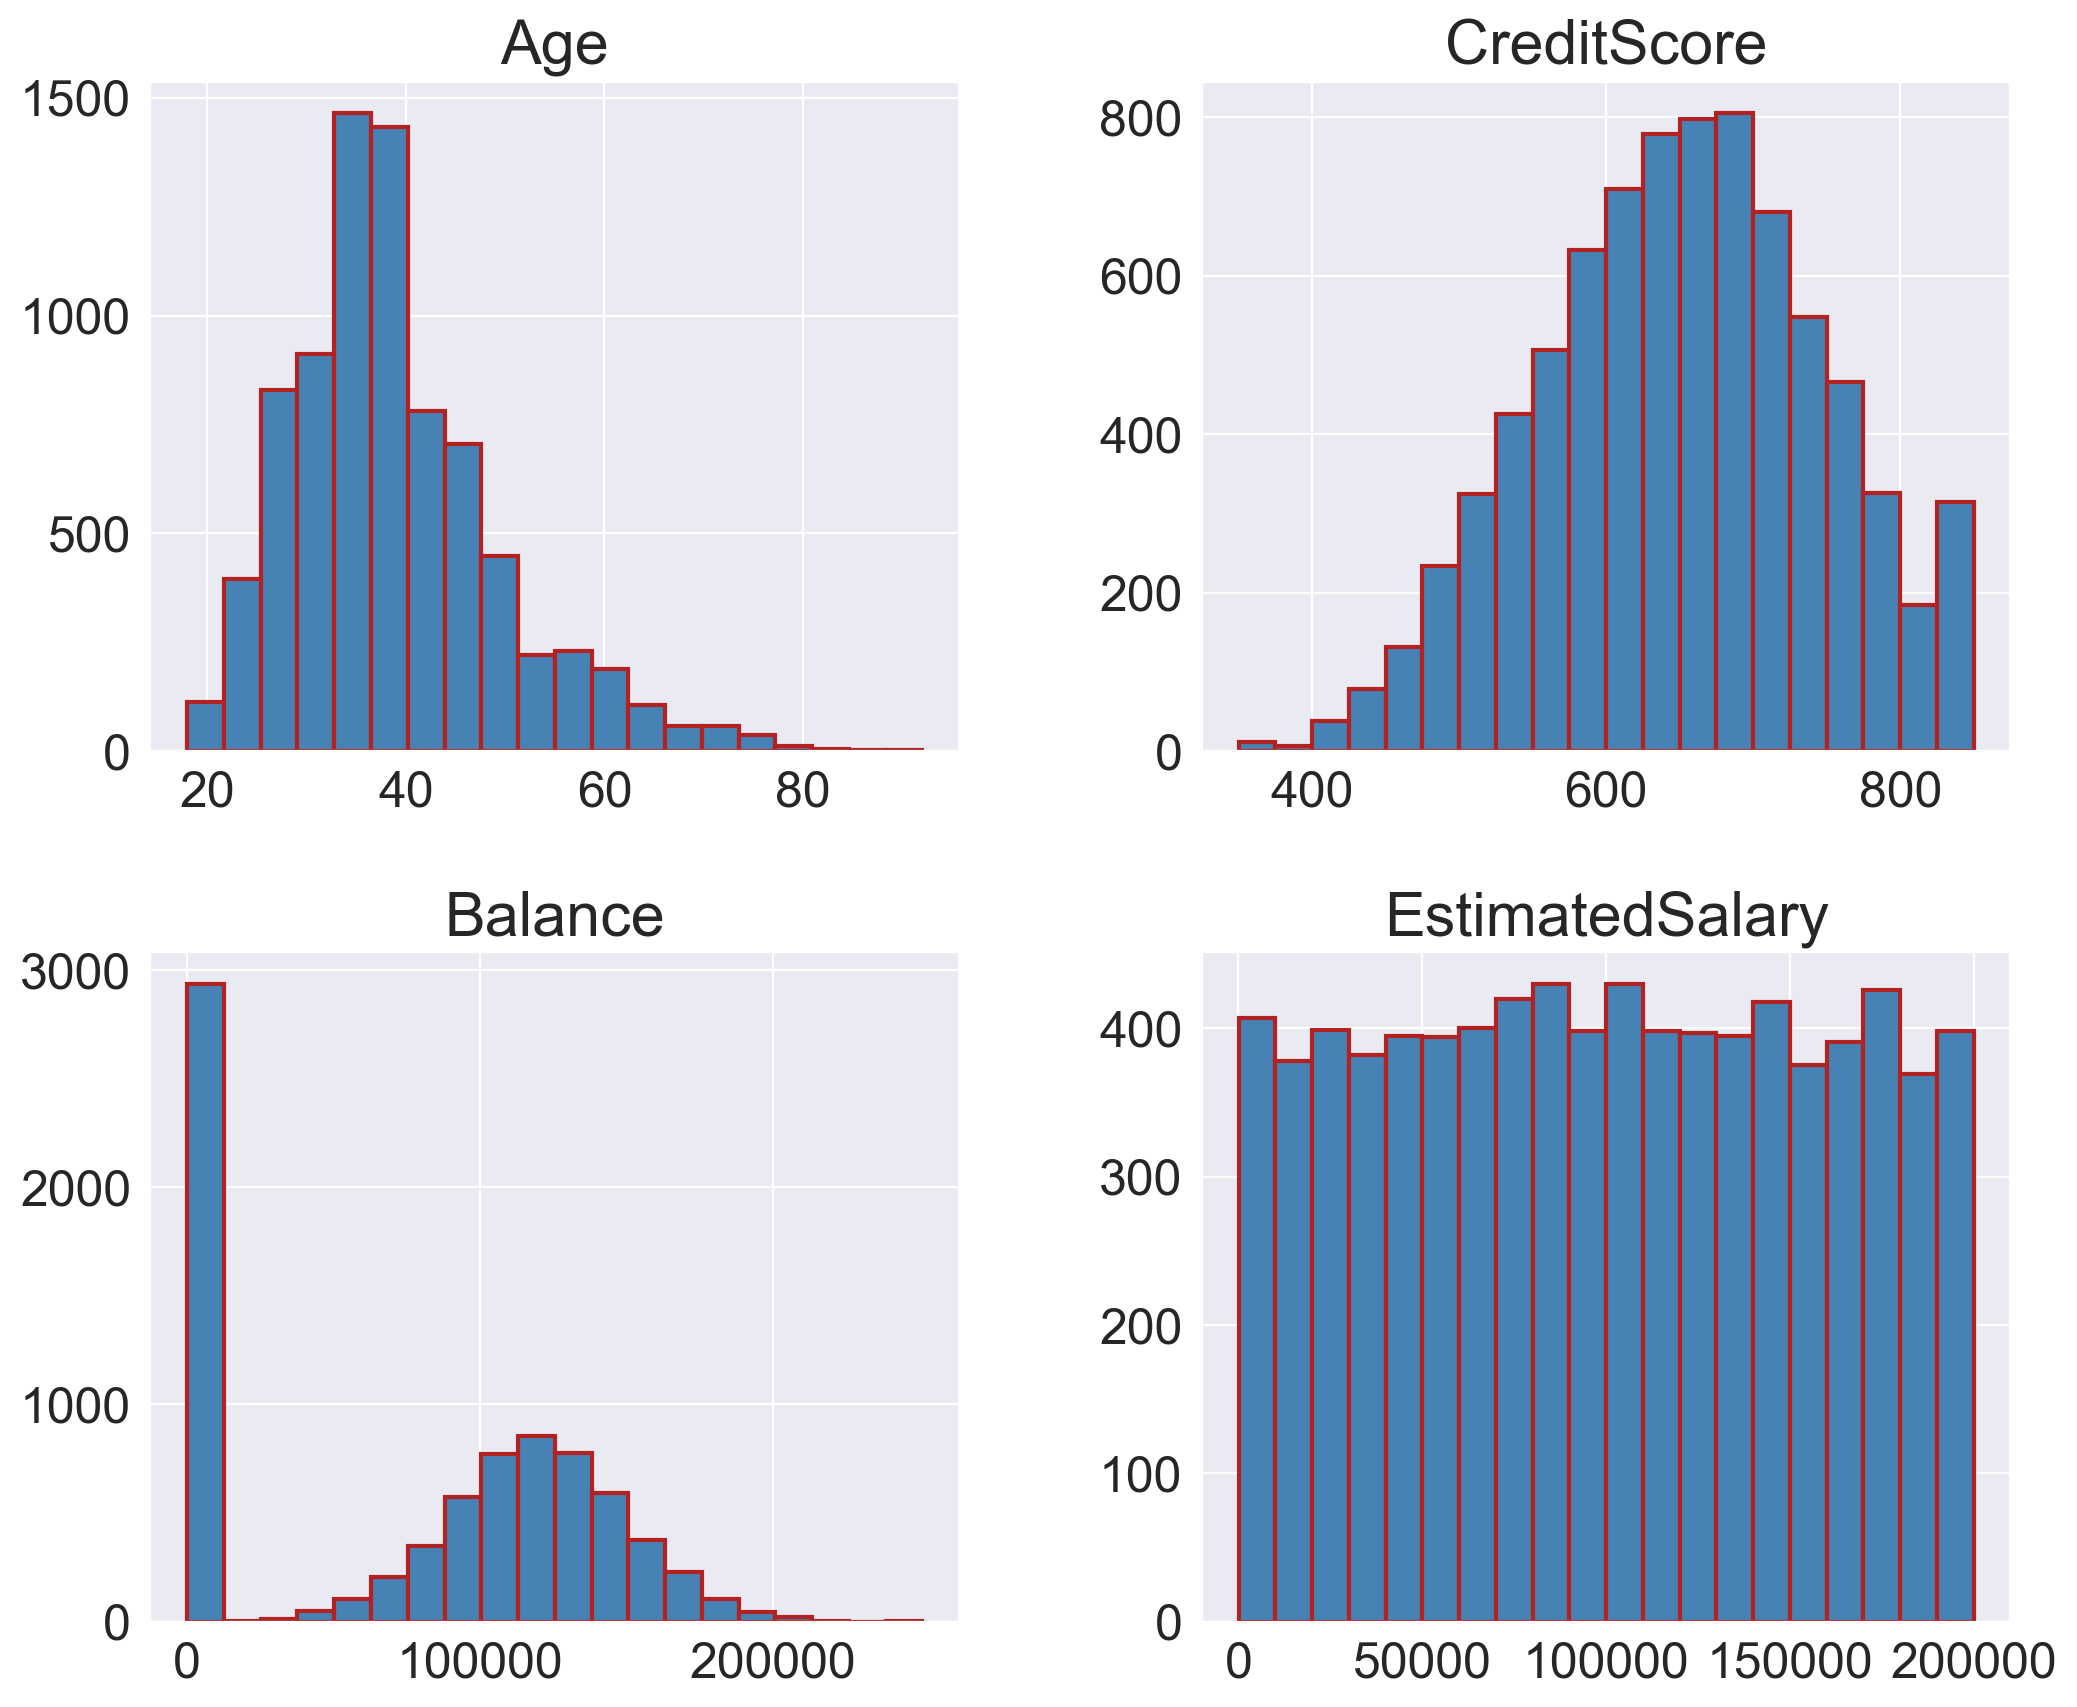

In [75]:
# # train_df[continuous].hist(figsize=(12, 10),
# #                           bins=20,
# #                           layout=(2, 2),
# #                           color='steelblue',
# #                           edgecolor='firebrick',
# #                           linewidth=1.5);



# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming `continuous` is a list of continuous column names from the `train_df` DataFrame

# # Create a stacked area chart for each continuous variable
# train_df[continuous].plot.area(figsize=(12, 10),
#                                color=['steelblue', 'orange', 'green', 'purple'],
#                                linewidth=1.5,
#                                alpha=0.7)  # Adjust alpha for transparency if needed


# # train_df[continuous].hist(figsize=(12, 10),
# #                           bins=20,
# #                           layout=(2, 2),
# #                           color='steelblue',
# #                           edgecolor='firebrick',
# #                           linewidth=1.5);
# # Set the title and labels for the plot
# plt.title('Stacked Area Charts for Continuous Variables')
# plt.xlabel('X-axis Label')
# plt.ylabel('Y-axis Label')

# # Show the legend (you can omit this line if you don't want the legend)
# plt.legend(loc='upper right')

# # Show the plot
# plt.show()




import pandas as pd
import matplotlib.pyplot as plt

# Assuming `continuous` is a list of continuous column names from the `train_df` DataFrame

# Create separate area charts for each continuous variable
#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

#train_df[continuous[0]].plot.area(ax=axes[0, 0], color='steelblue', linewidth=1.5, alpha=0.7)
#train_df[continuous[1]].plot.area(ax=axes[0, 1], color='orange', linewidth=1.5, alpha=0.7)
#train_df[continuous[2]].plot.area(ax=axes[1, 0], color='green', linewidth=1.5, alpha=0.7)
#train_df[continuous[3]].plot.area(ax=axes[1, 1], color='purple', linewidth=1.5, alpha=0.7)

# Set the titles and labels for each subplot
#axes[0, 0].set_title(continuous[0])
#axes[0, 1].set_title(continuous[1])
##axes[1, 0].set_title(continuous[2])
#axes[1, 1].set_title(continuous[3])

# Set common x and y-axis labels
#fig.text(0.5, 0.04, 'X-axis Label', ha='center')
#fig.text(0.04, 0.5, 'Y-axis Label', va='center', rotation='vertical')

# Show the legend (you can omit this line if you don't want the legend)
#plt.legend(loc='upper right')

# Adjust layout for better appearance
#plt.tight_layout()

# Show the plot
#plt.show()

train_df[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);

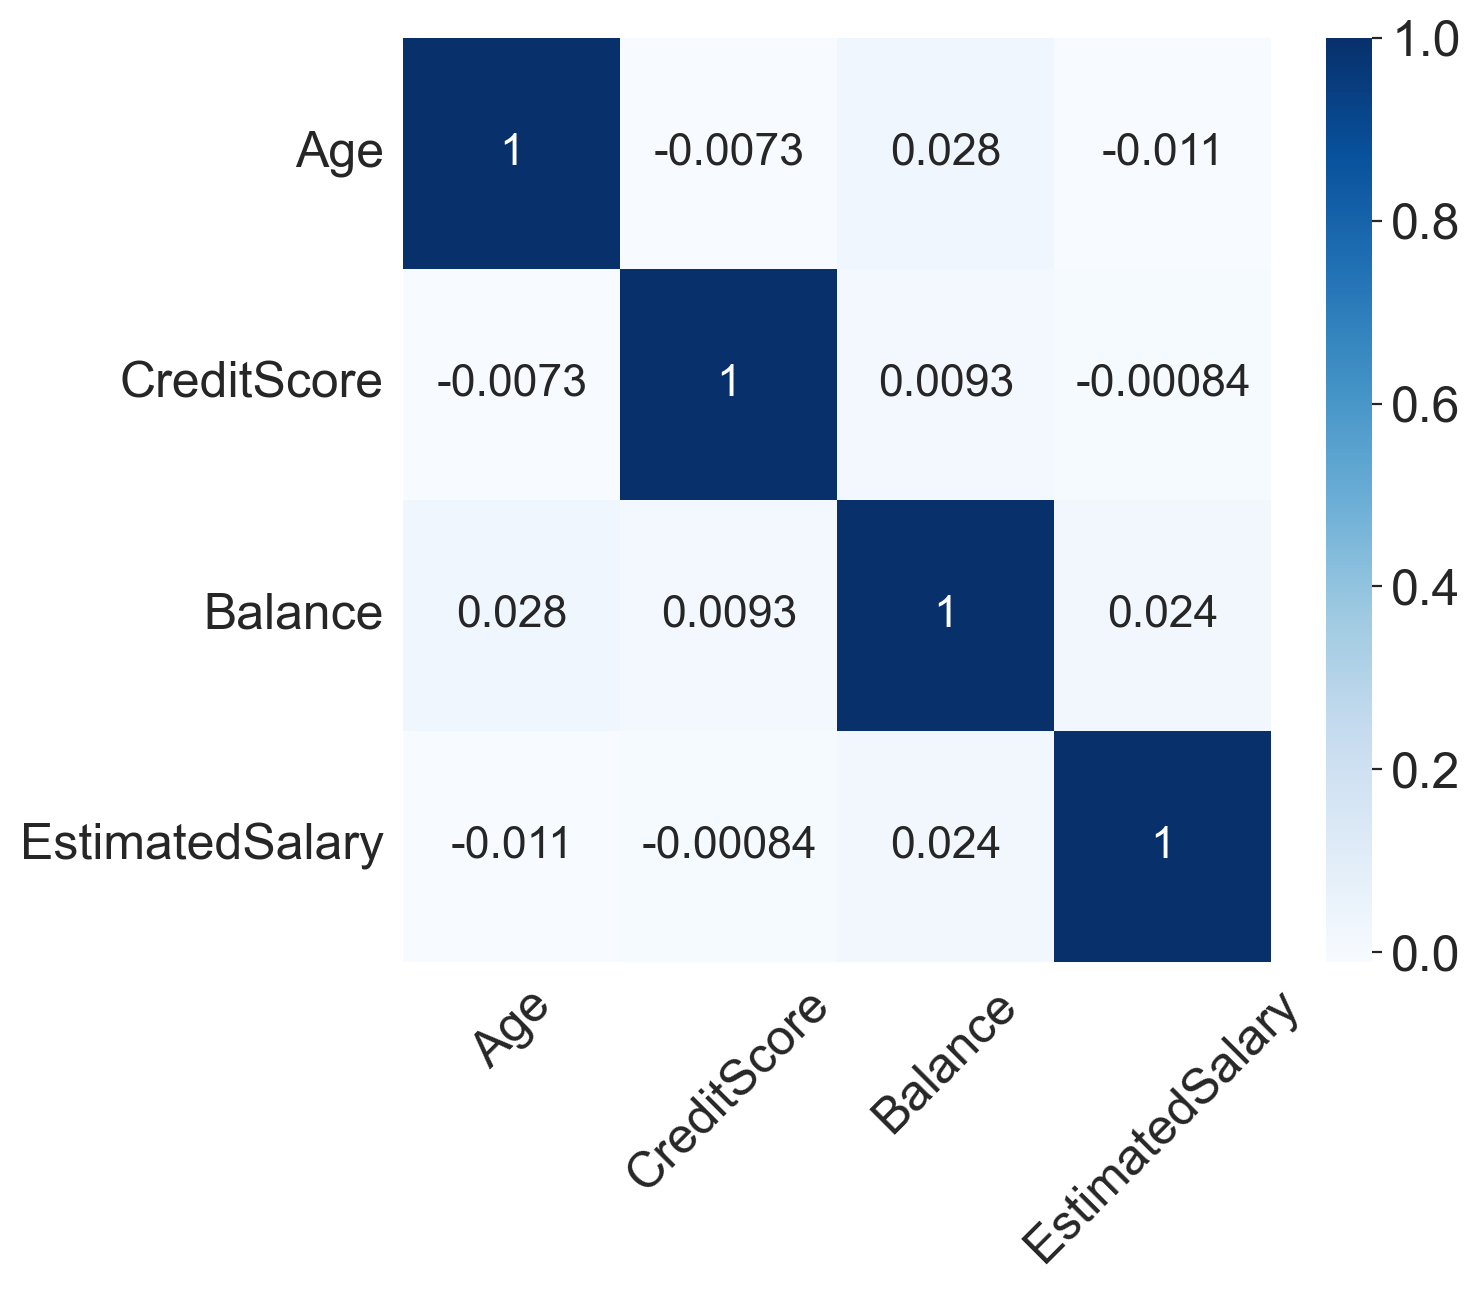

In [76]:

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

In [77]:
def plot_continuous(feature):
    '''Plot a histogram and violin plot for the churned and retained distributions for the specified feature.'''
    
    # Create a copy of the training dataset to avoid modifying the original data
    df_func = train_df.copy()
    # Convert the 'Exited' column to a categorical variable to use in the violin plot
    df_func['Exited'] = df_func['Exited'].astype('category')

    # Create a figure with two subplots, sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 7), sharex=True, gridspec_kw={'height_ratios': (.7, .3)})

    # Plot histograms for the specified feature for both retained and churned customers
    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df, x=feature, bins=15, color=color, alpha=0.66, edgecolor='firebrick', label=label, kde=False, ax=ax1)
    ax1.legend()

    # Create a violin plot to compare the distributions of the specified feature between retained and churned customers
    sns.violinplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2, inner='quartiles')
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    # Adjust the layout to prevent overlapping of the subplots
    plt.tight_layout()

# Call this function to plot the histograms and violin plot for a specific feature
# For example: plot_continuous('Age')


C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\3569952562.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['Retained', 'Churned'])


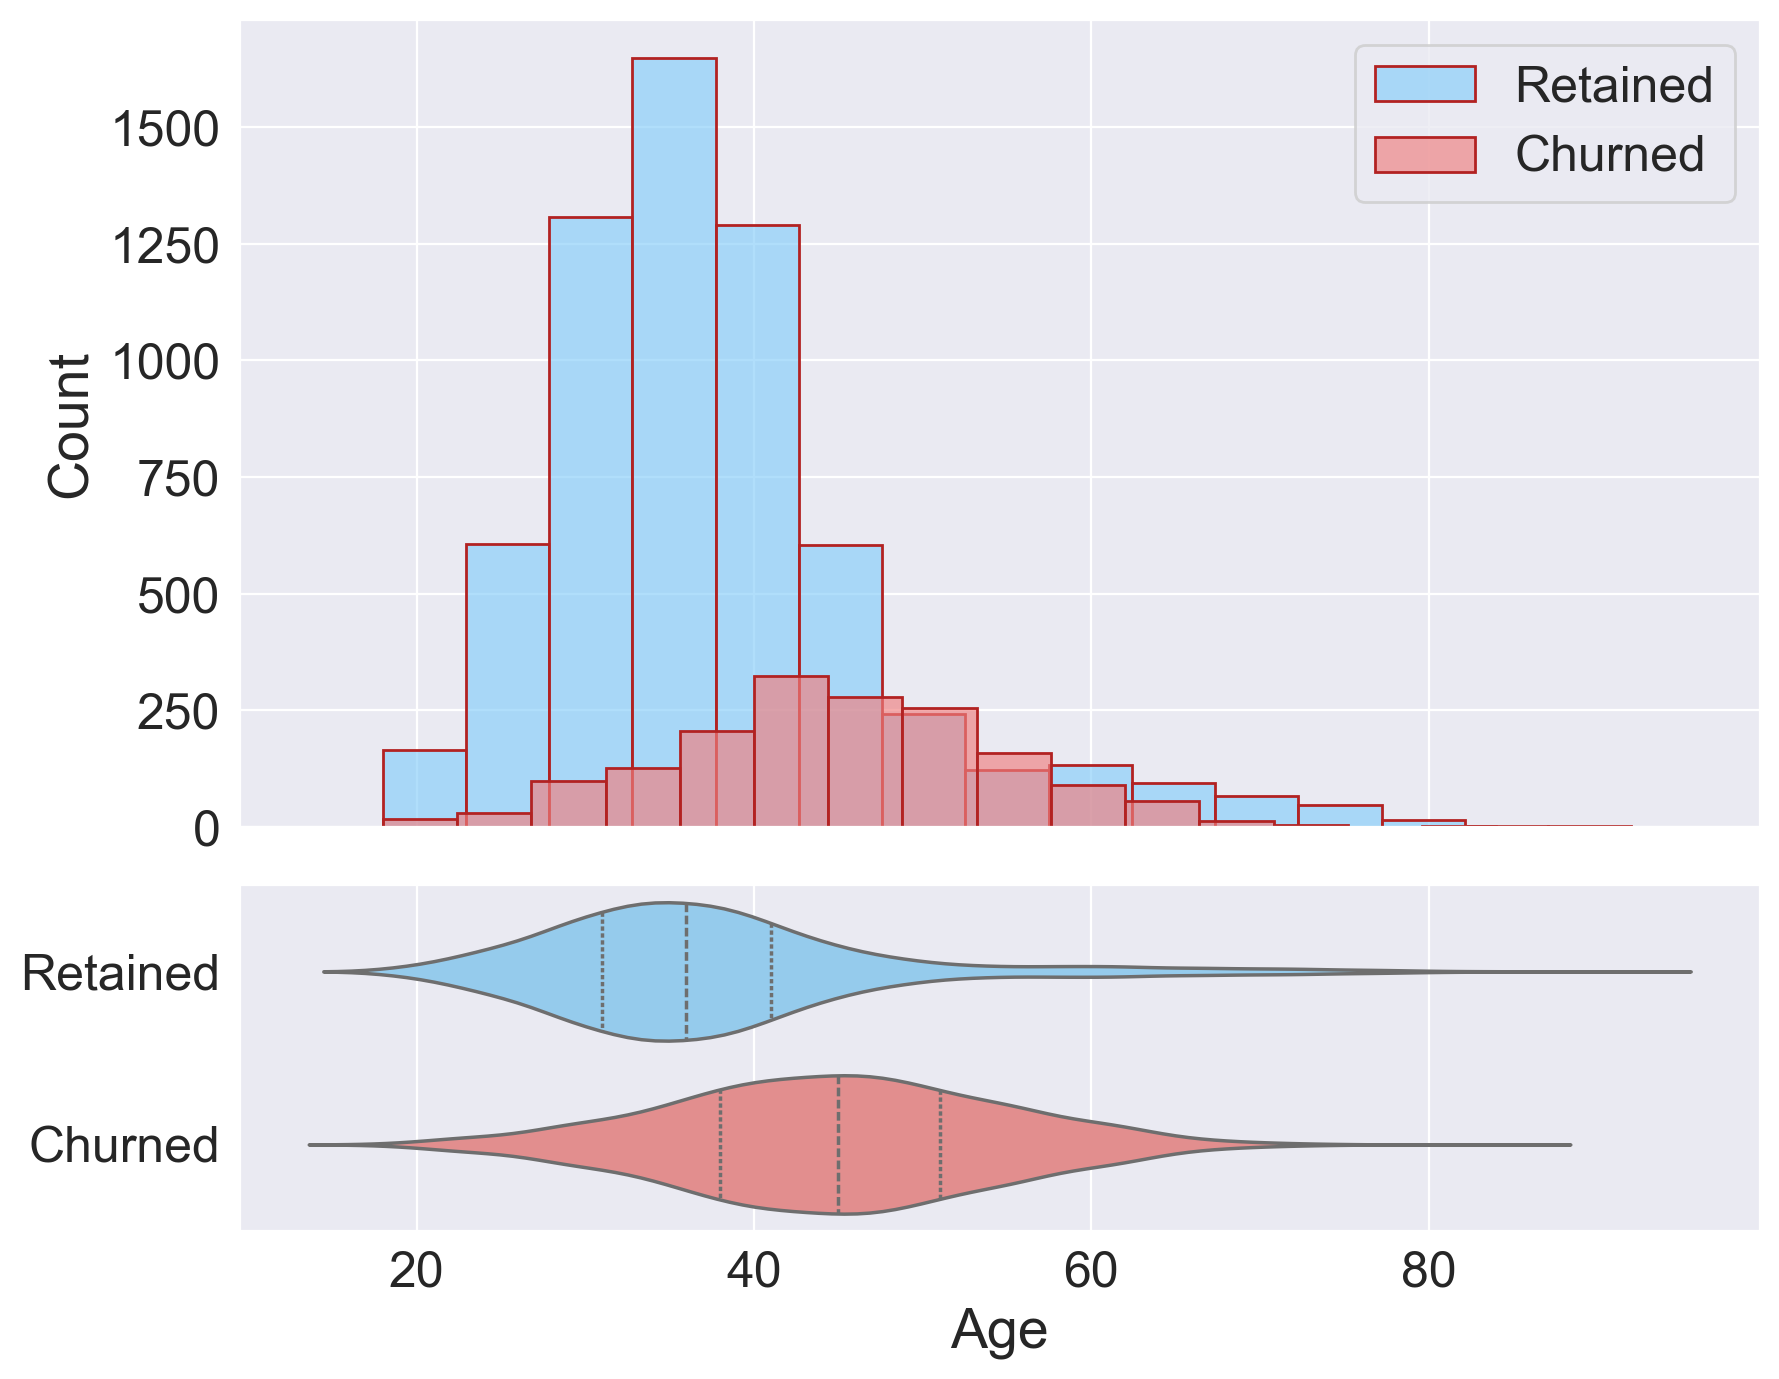

In [78]:
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

# Exploratory Data Analysis

C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\3569952562.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['Retained', 'Churned'])


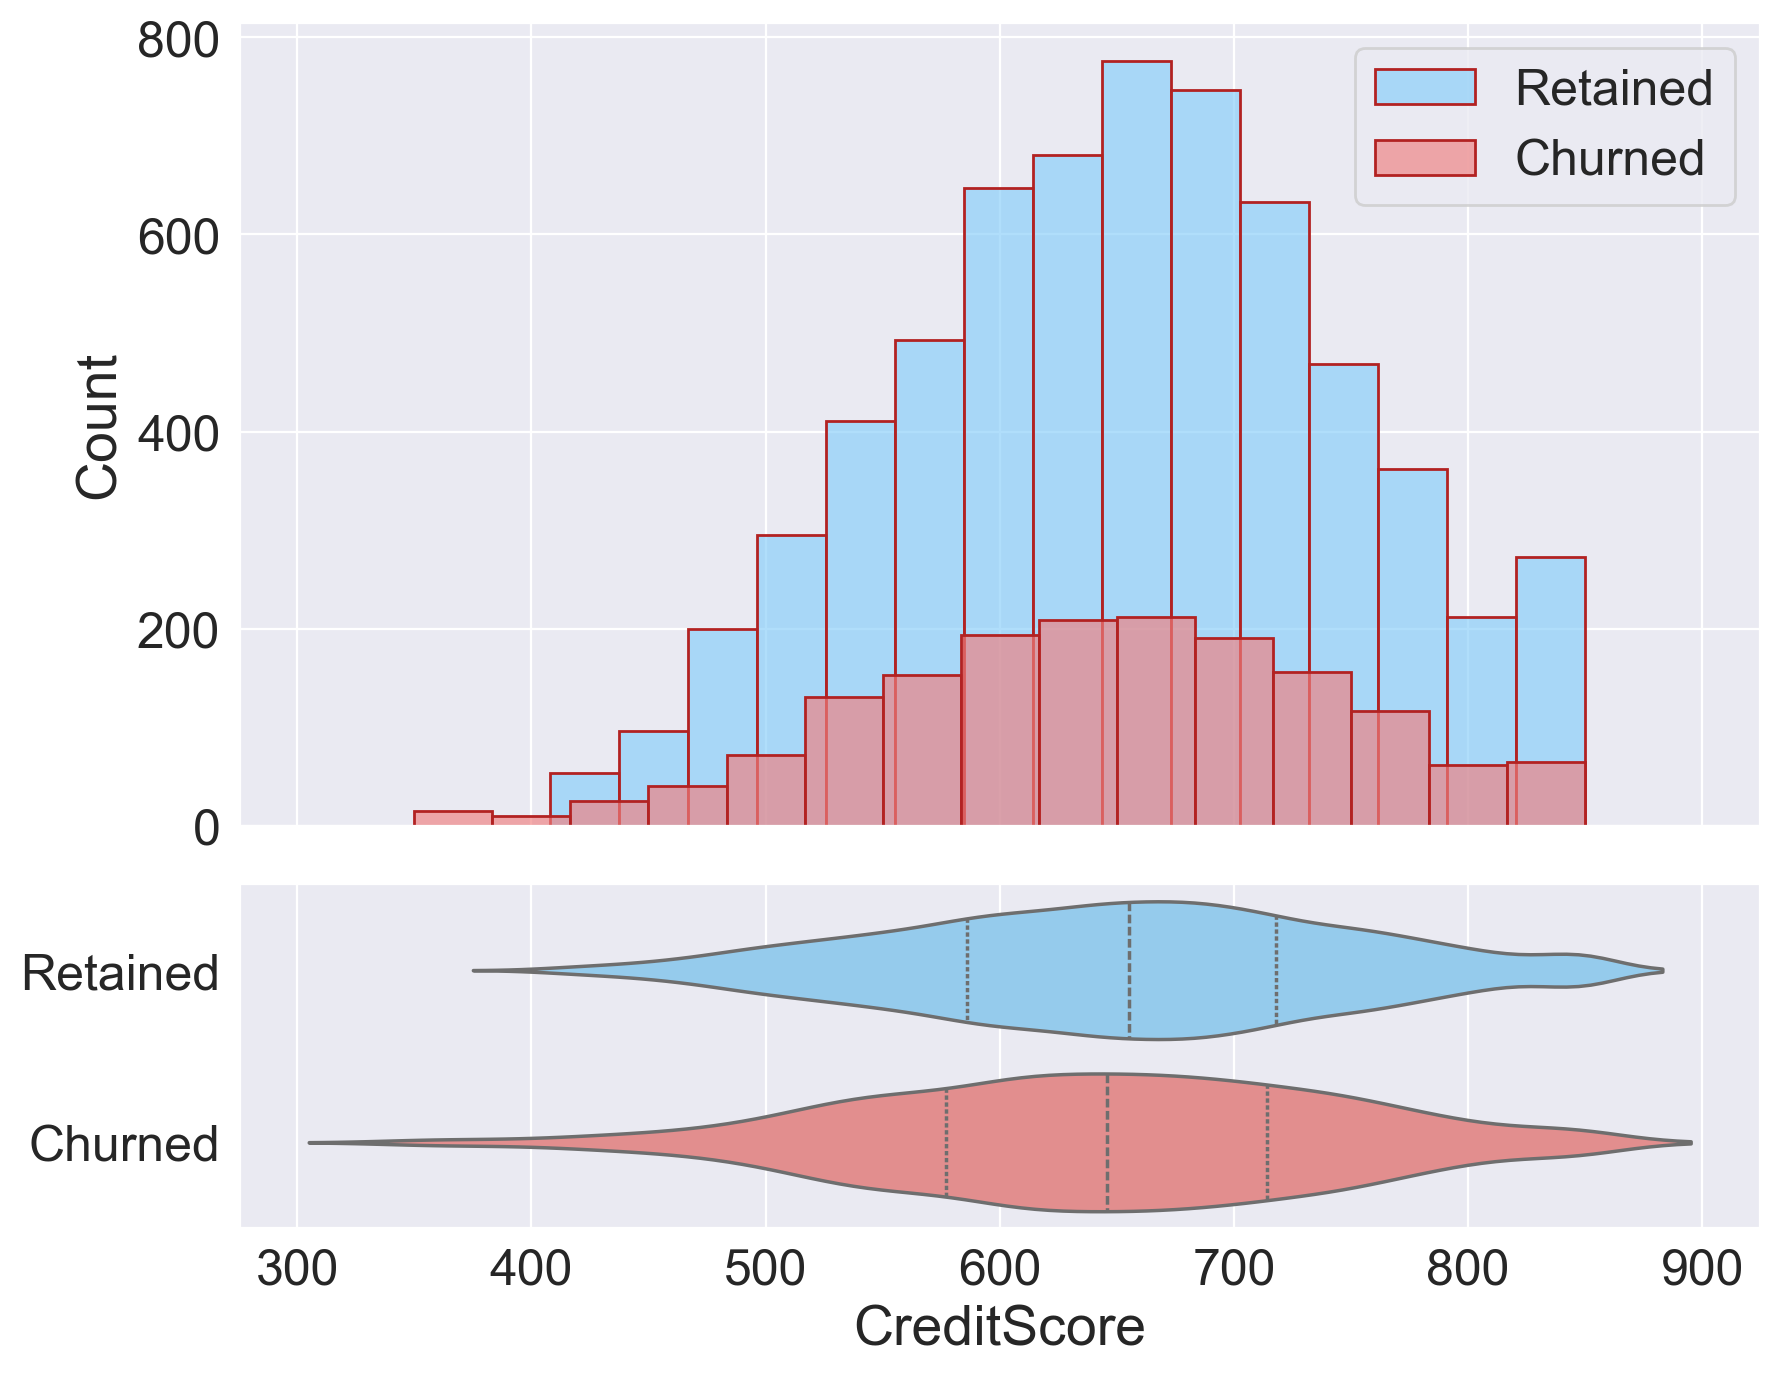

In [79]:
plot_continuous('CreditScore')


C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\3569952562.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['Retained', 'Churned'])


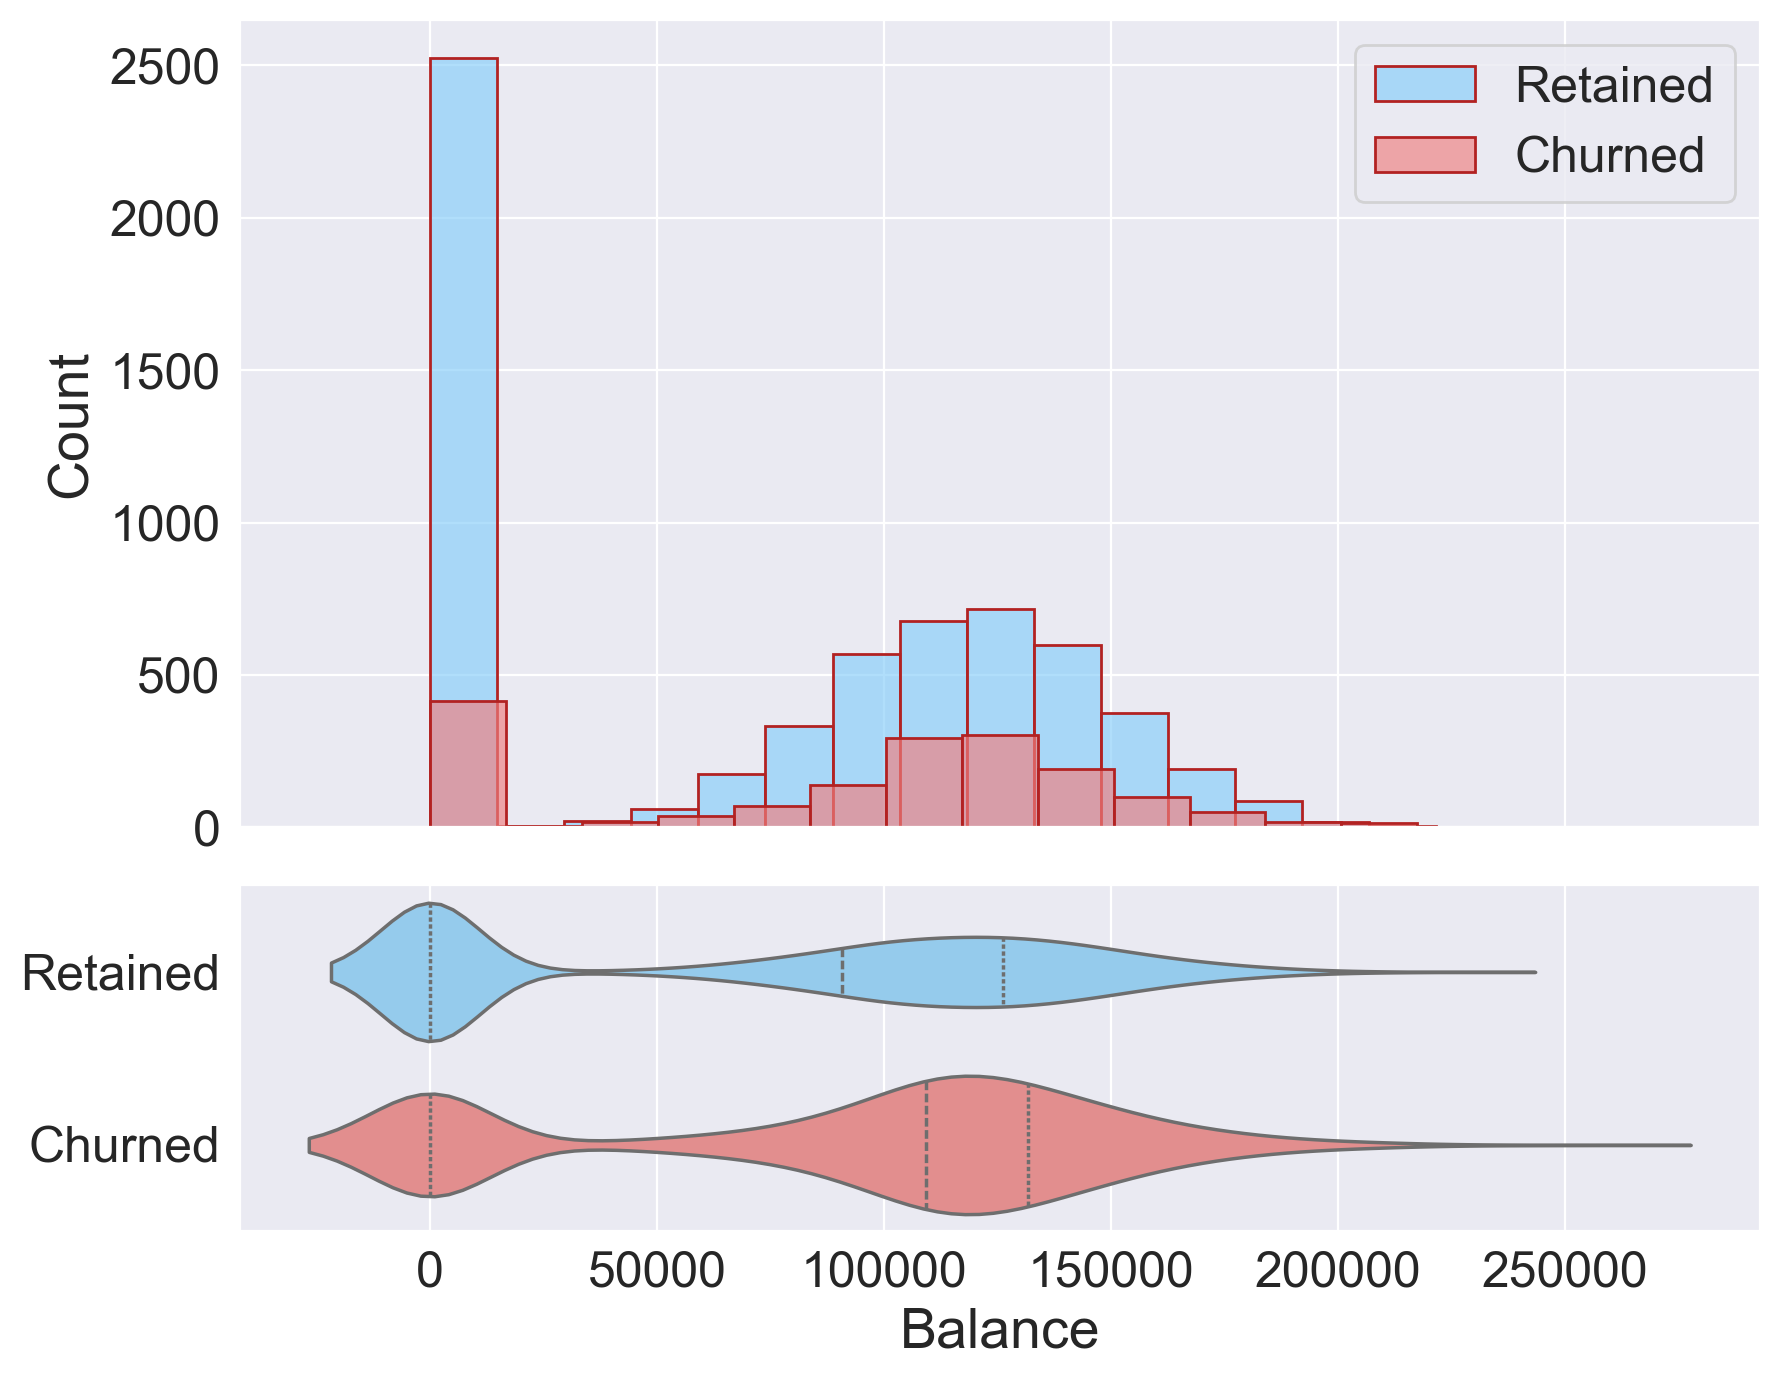

In [80]:
plot_continuous('Balance')


C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\3569952562.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['Retained', 'Churned'])


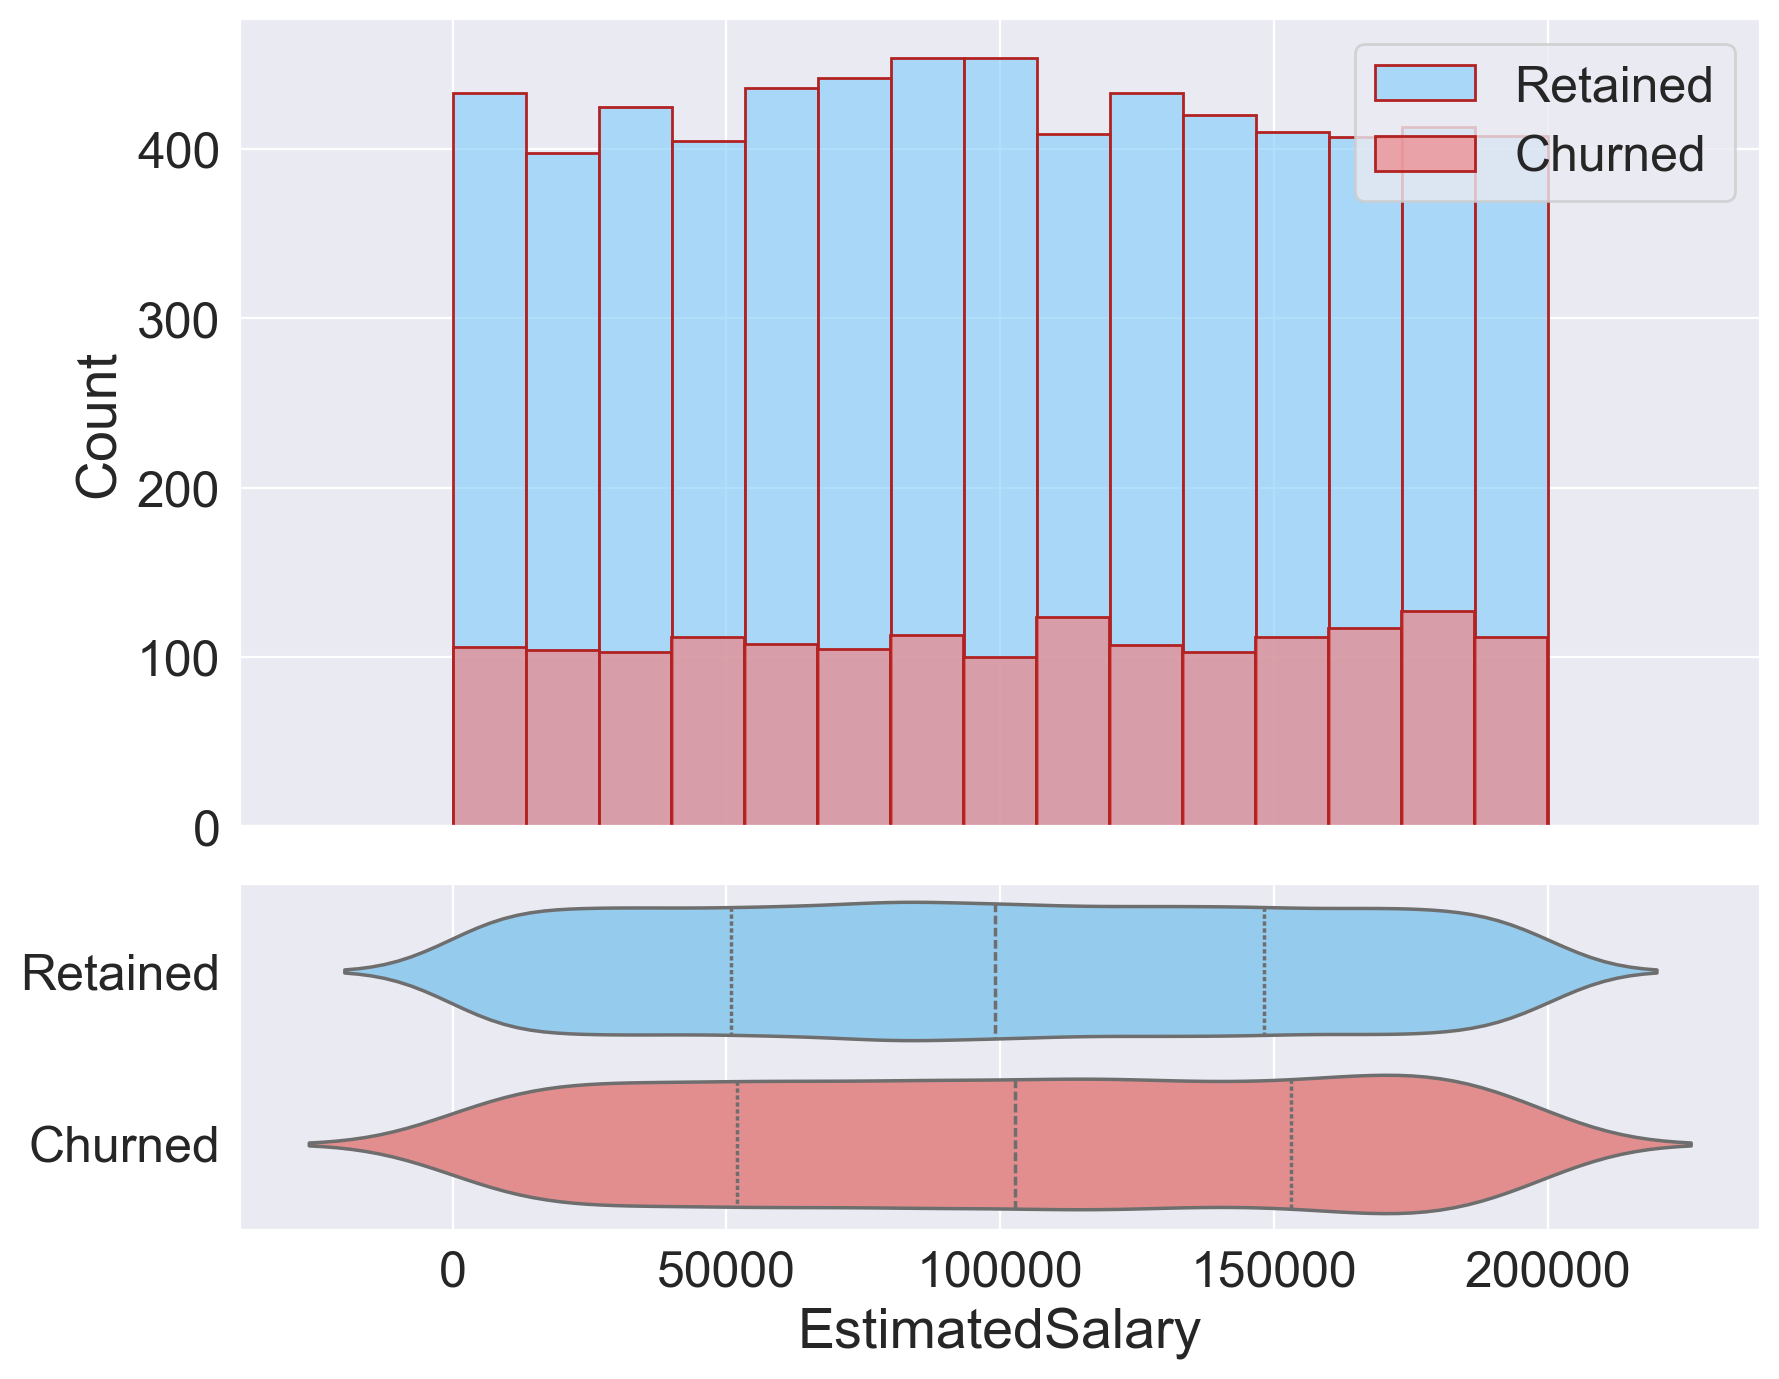

In [81]:
plot_continuous('EstimatedSalary')


C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\2825123671.py:9: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\2825123671.py:9: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\2825123671.py:9: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\2825123671.py:9: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\2825123671.py:9: UserWarning: The palette list has mo

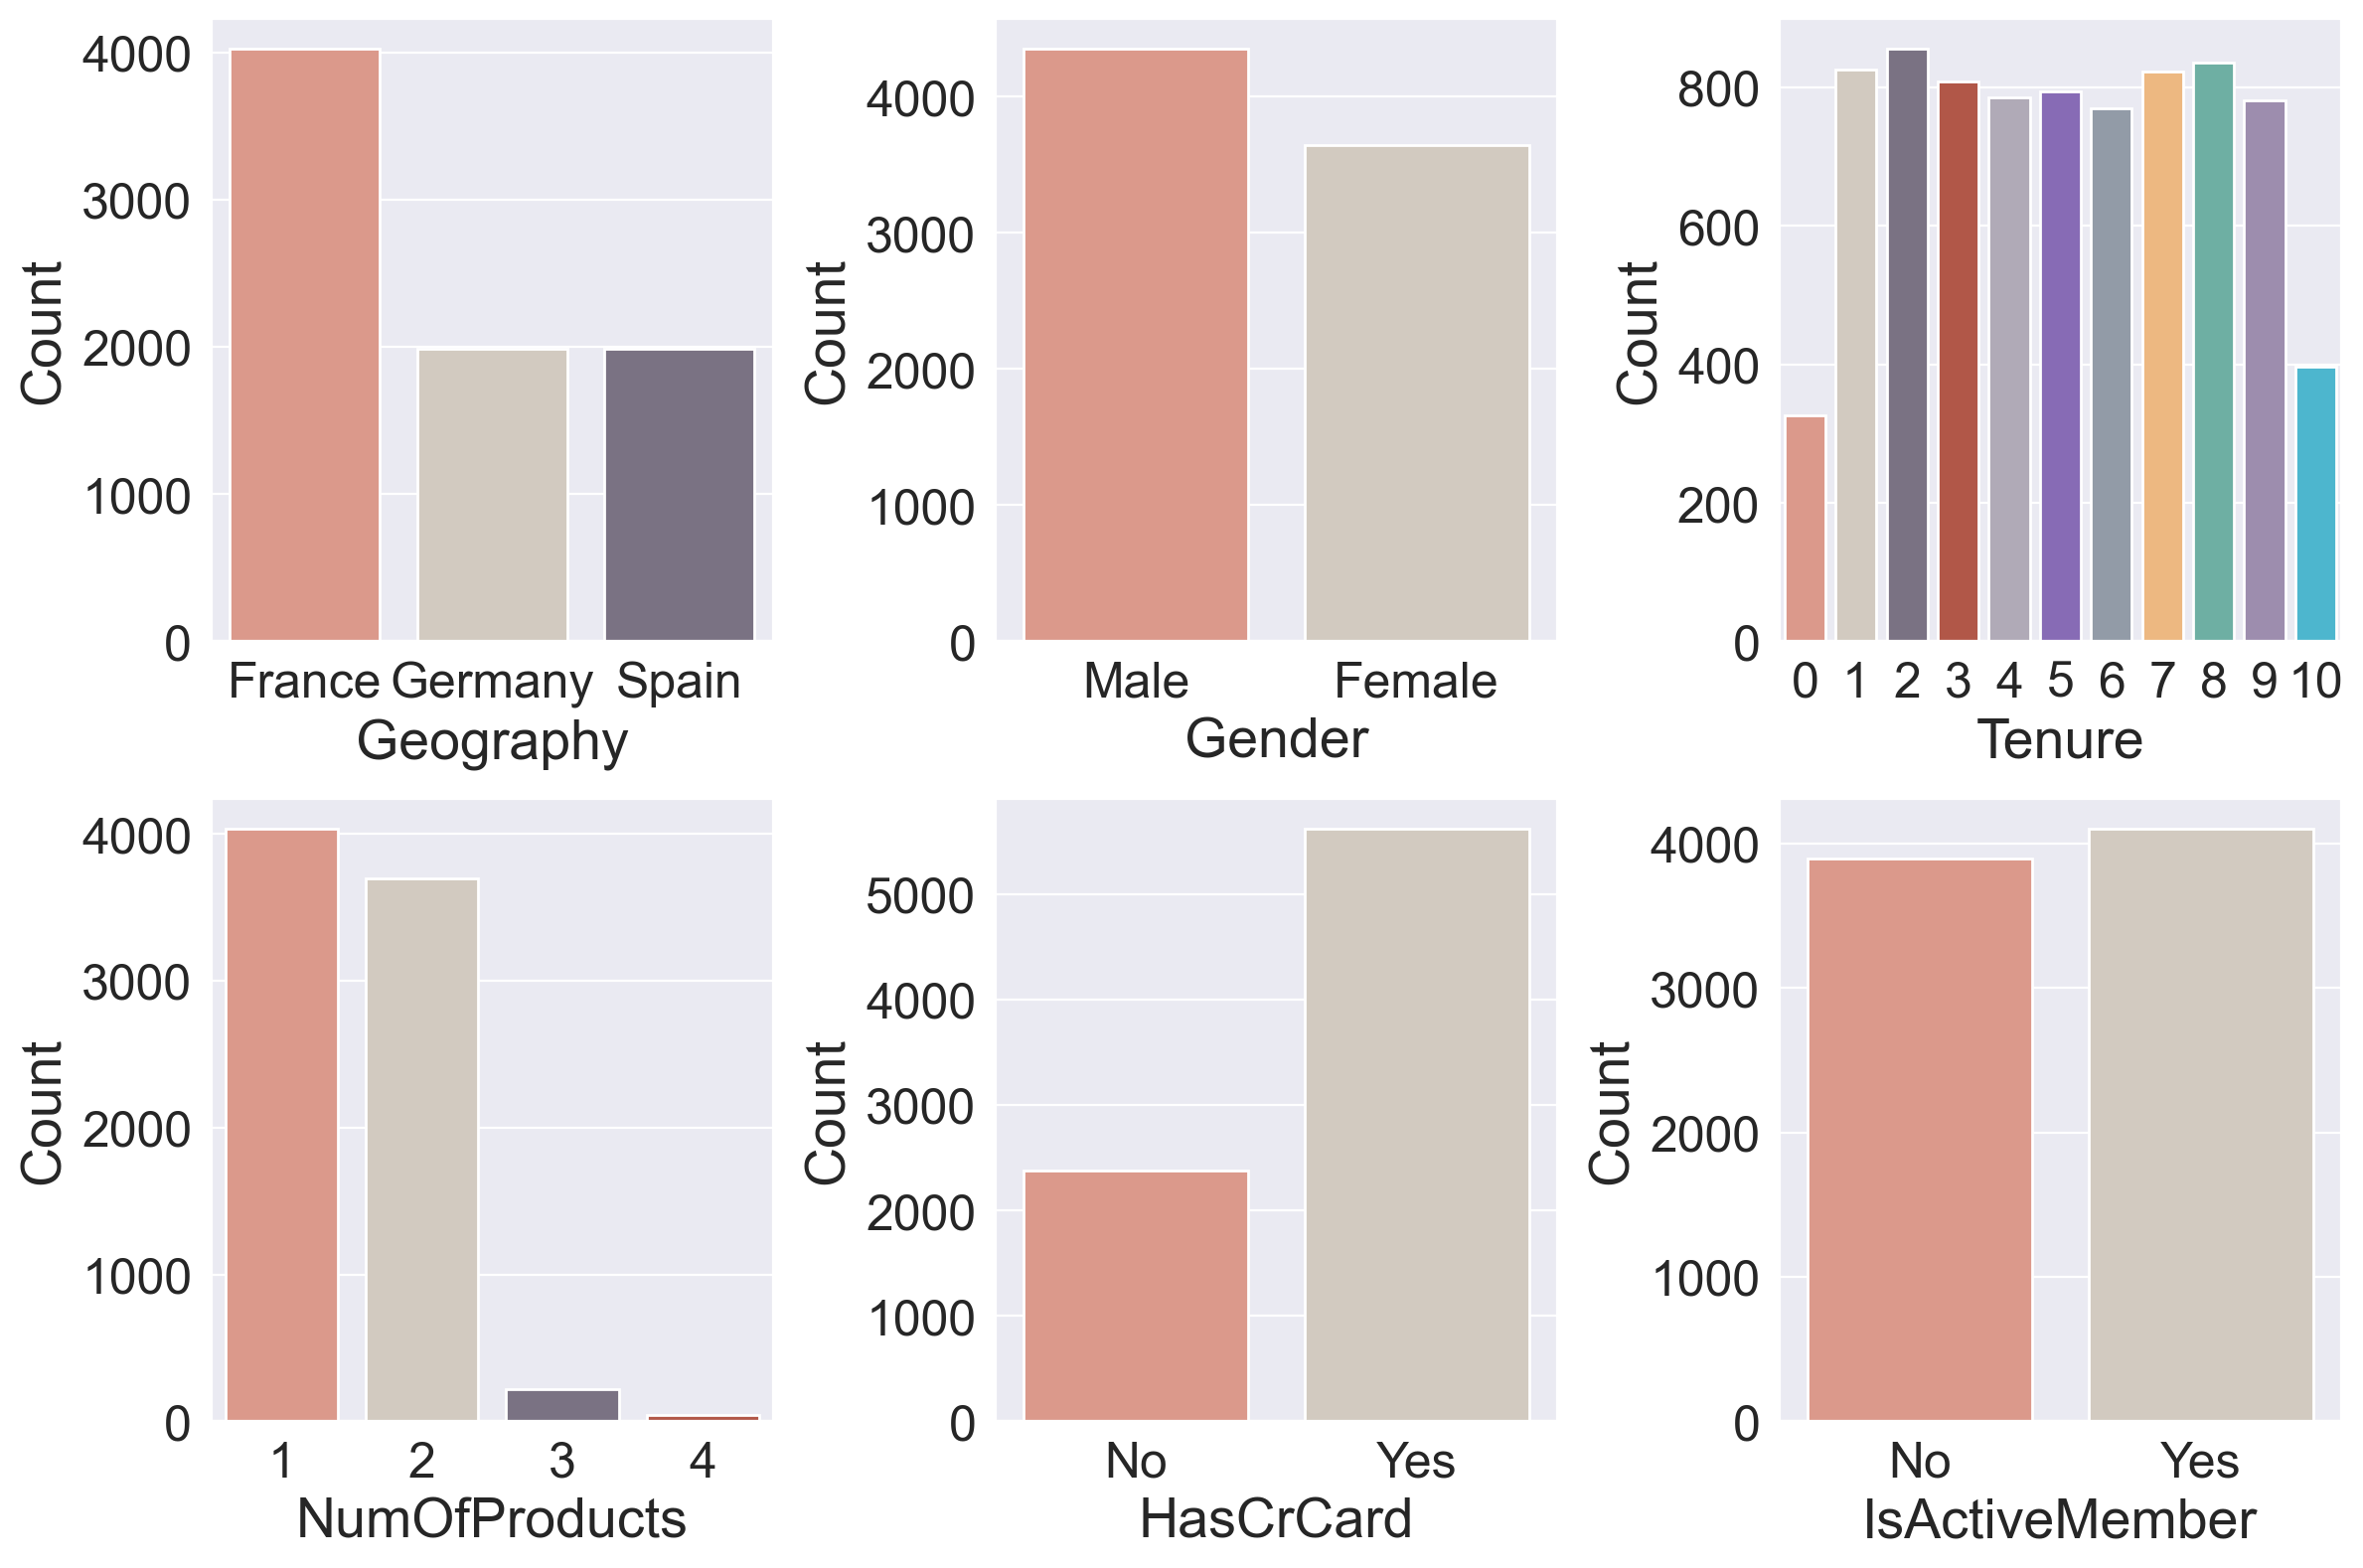

In [82]:
df_cat = train_df[categorical]
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();


C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\1514023485.py:12: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.barplot(x=feature, y='Exited', data=train_df, palette=colors_cat, ax=ax2)


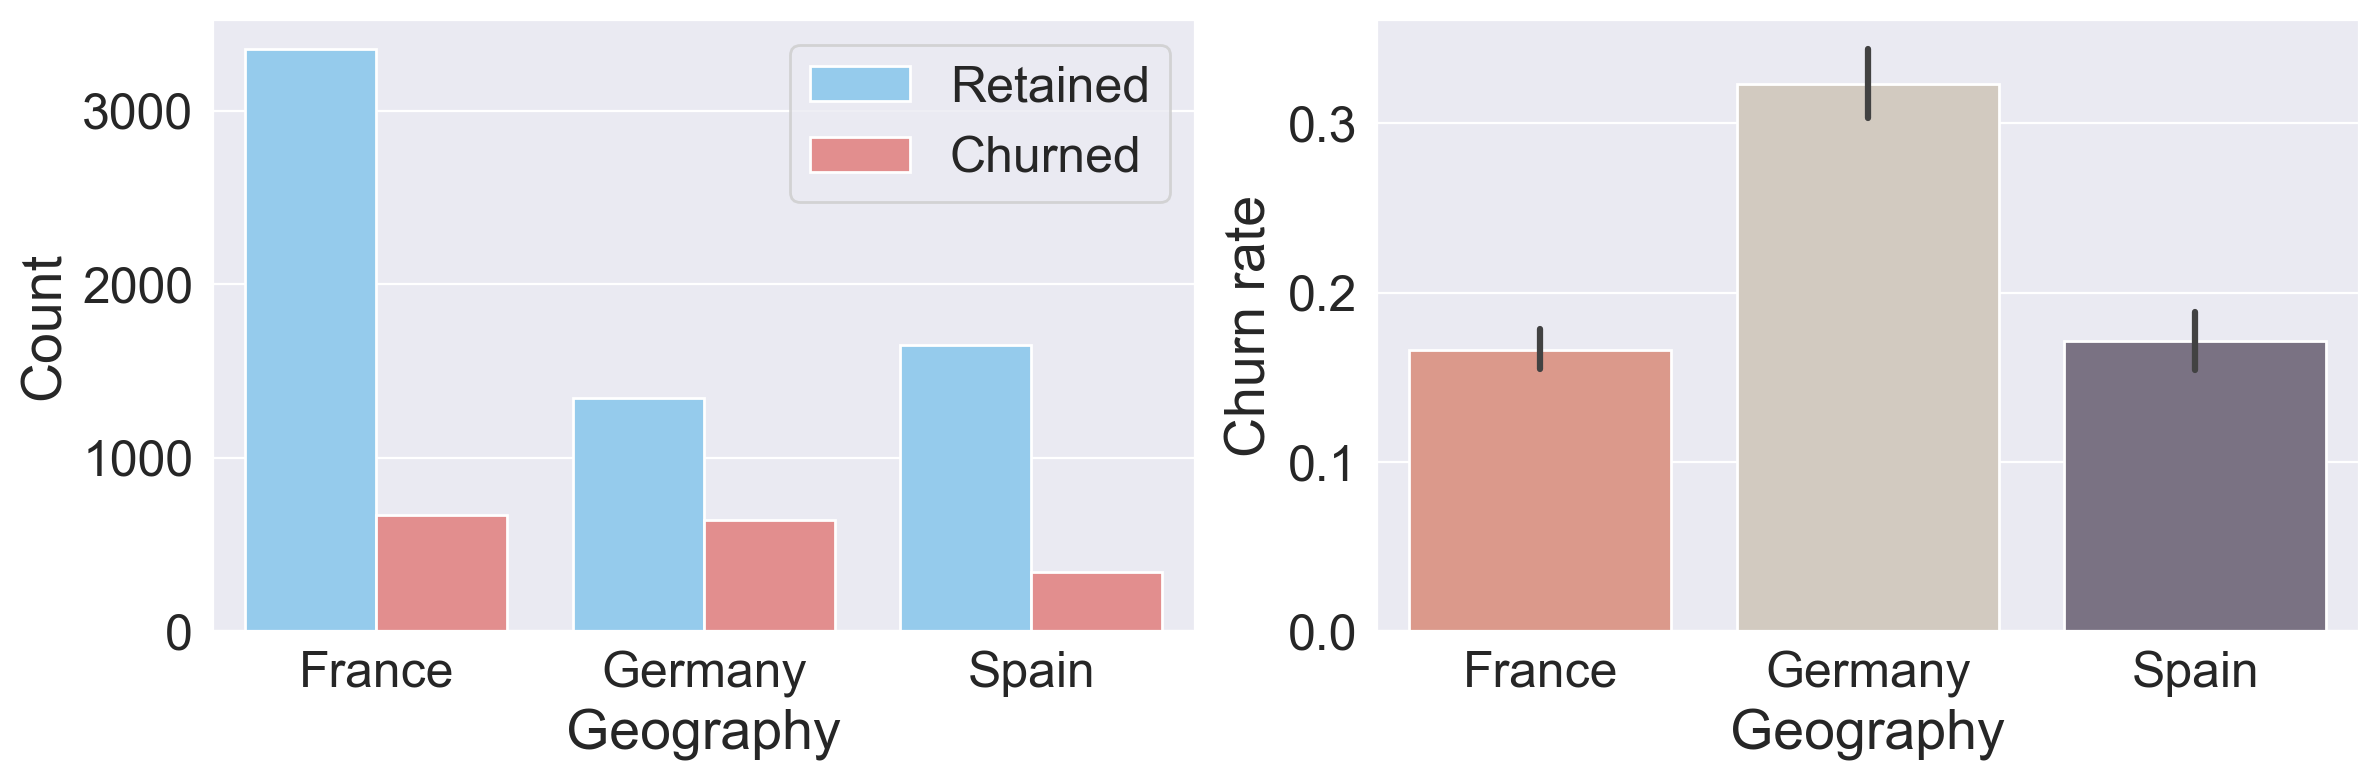

In [83]:
plot_categorical('Geography')


C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\1514023485.py:12: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(x=feature, y='Exited', data=train_df, palette=colors_cat, ax=ax2)


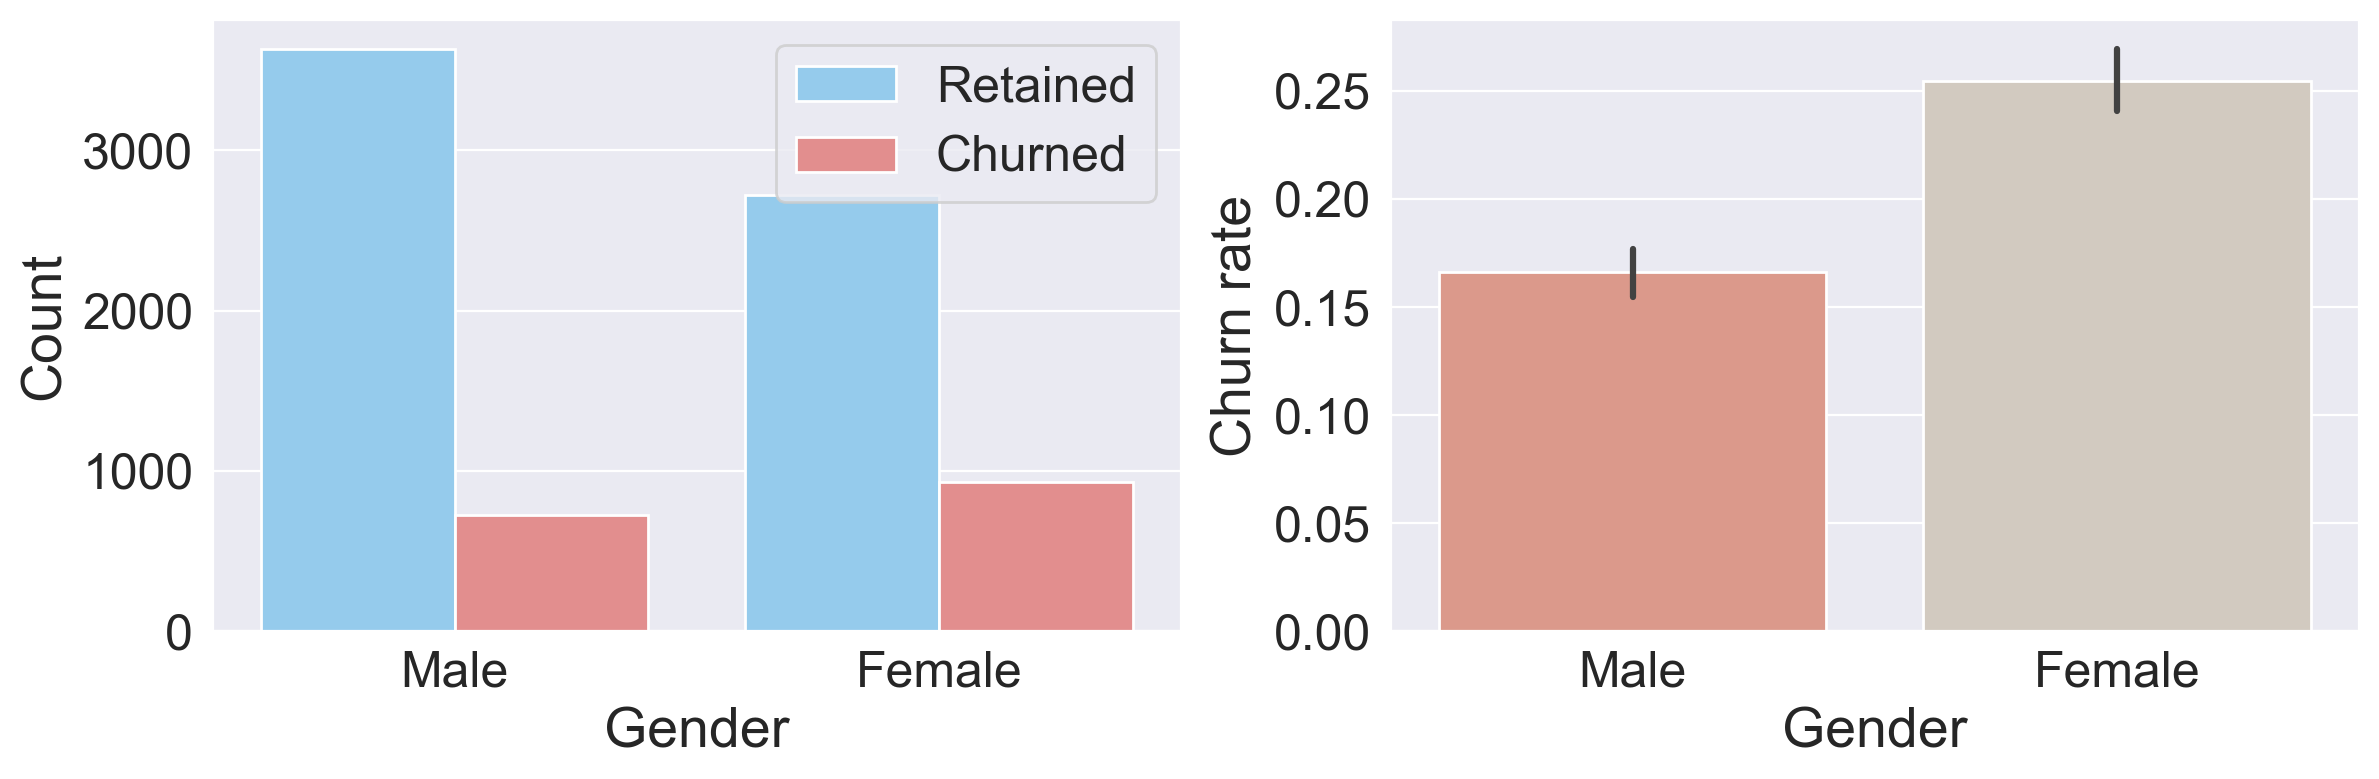

In [84]:
plot_categorical('Gender')


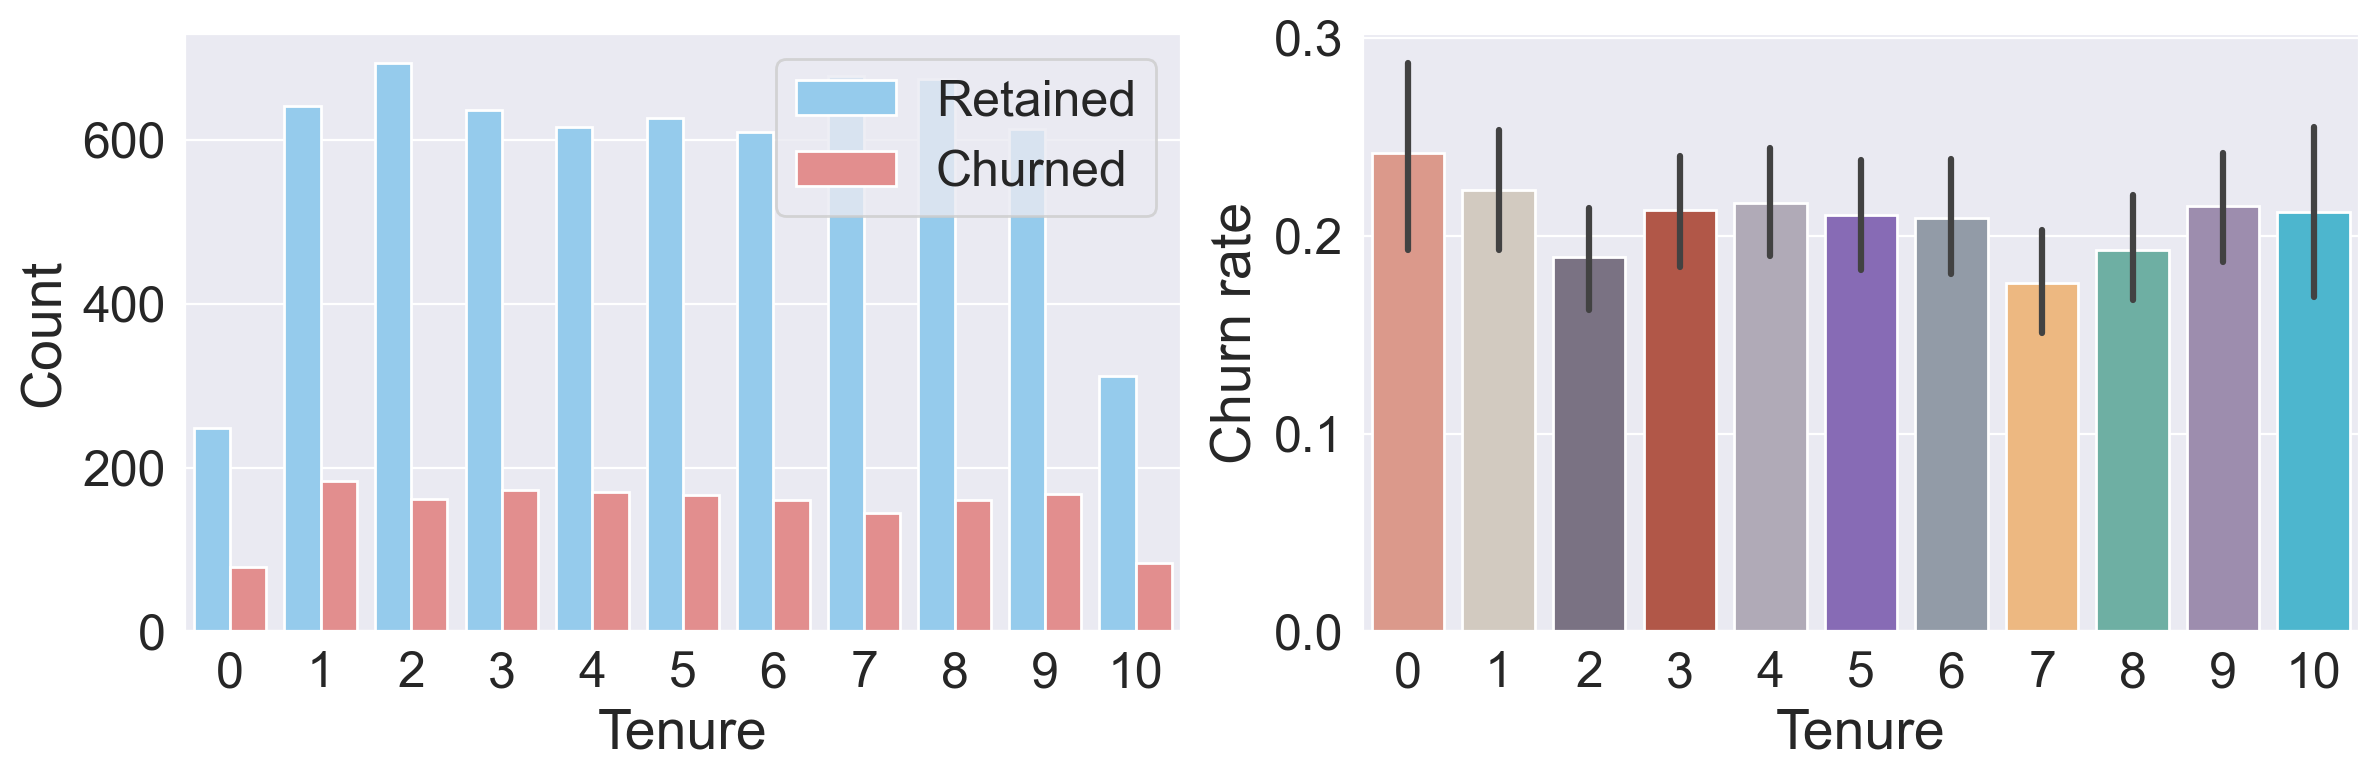

In [85]:
plot_categorical('Tenure')


C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\1514023485.py:12: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns.barplot(x=feature, y='Exited', data=train_df, palette=colors_cat, ax=ax2)


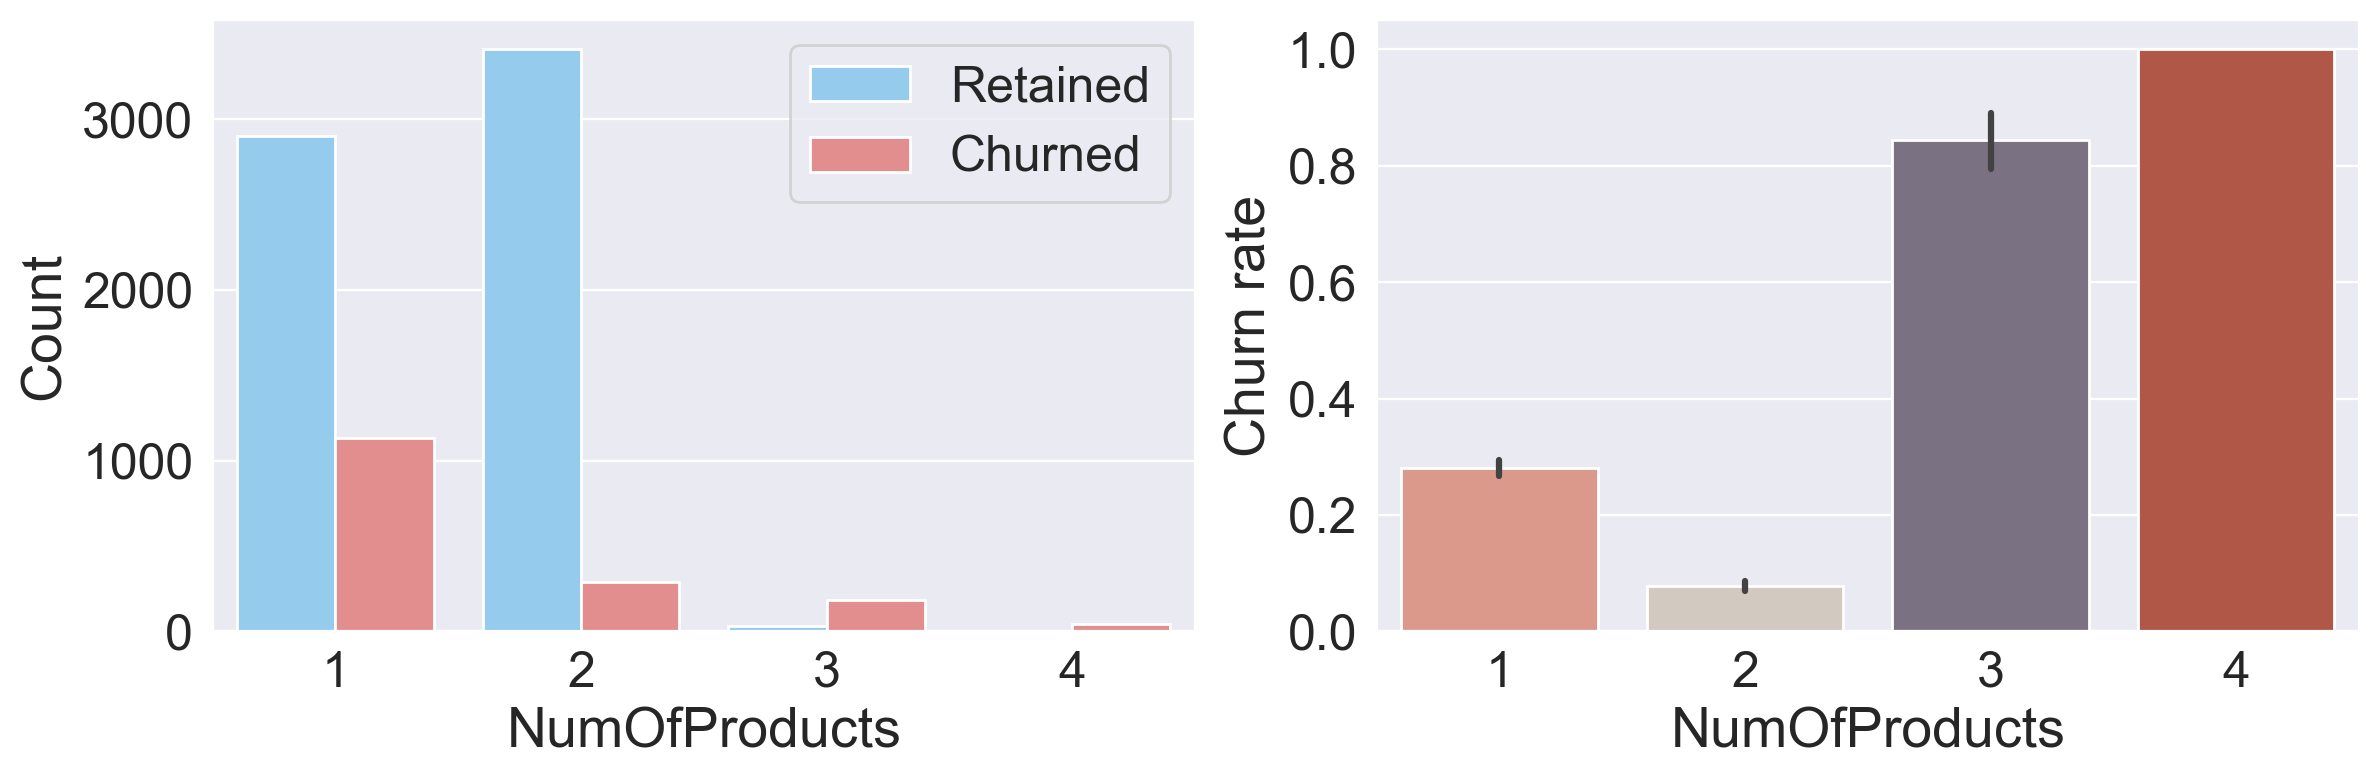

In [86]:
plot_categorical('NumOfProducts')


C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\1514023485.py:12: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(x=feature, y='Exited', data=train_df, palette=colors_cat, ax=ax2)
C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\1514023485.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['No', 'Yes'])
C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\1514023485.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['No', 'Yes'])


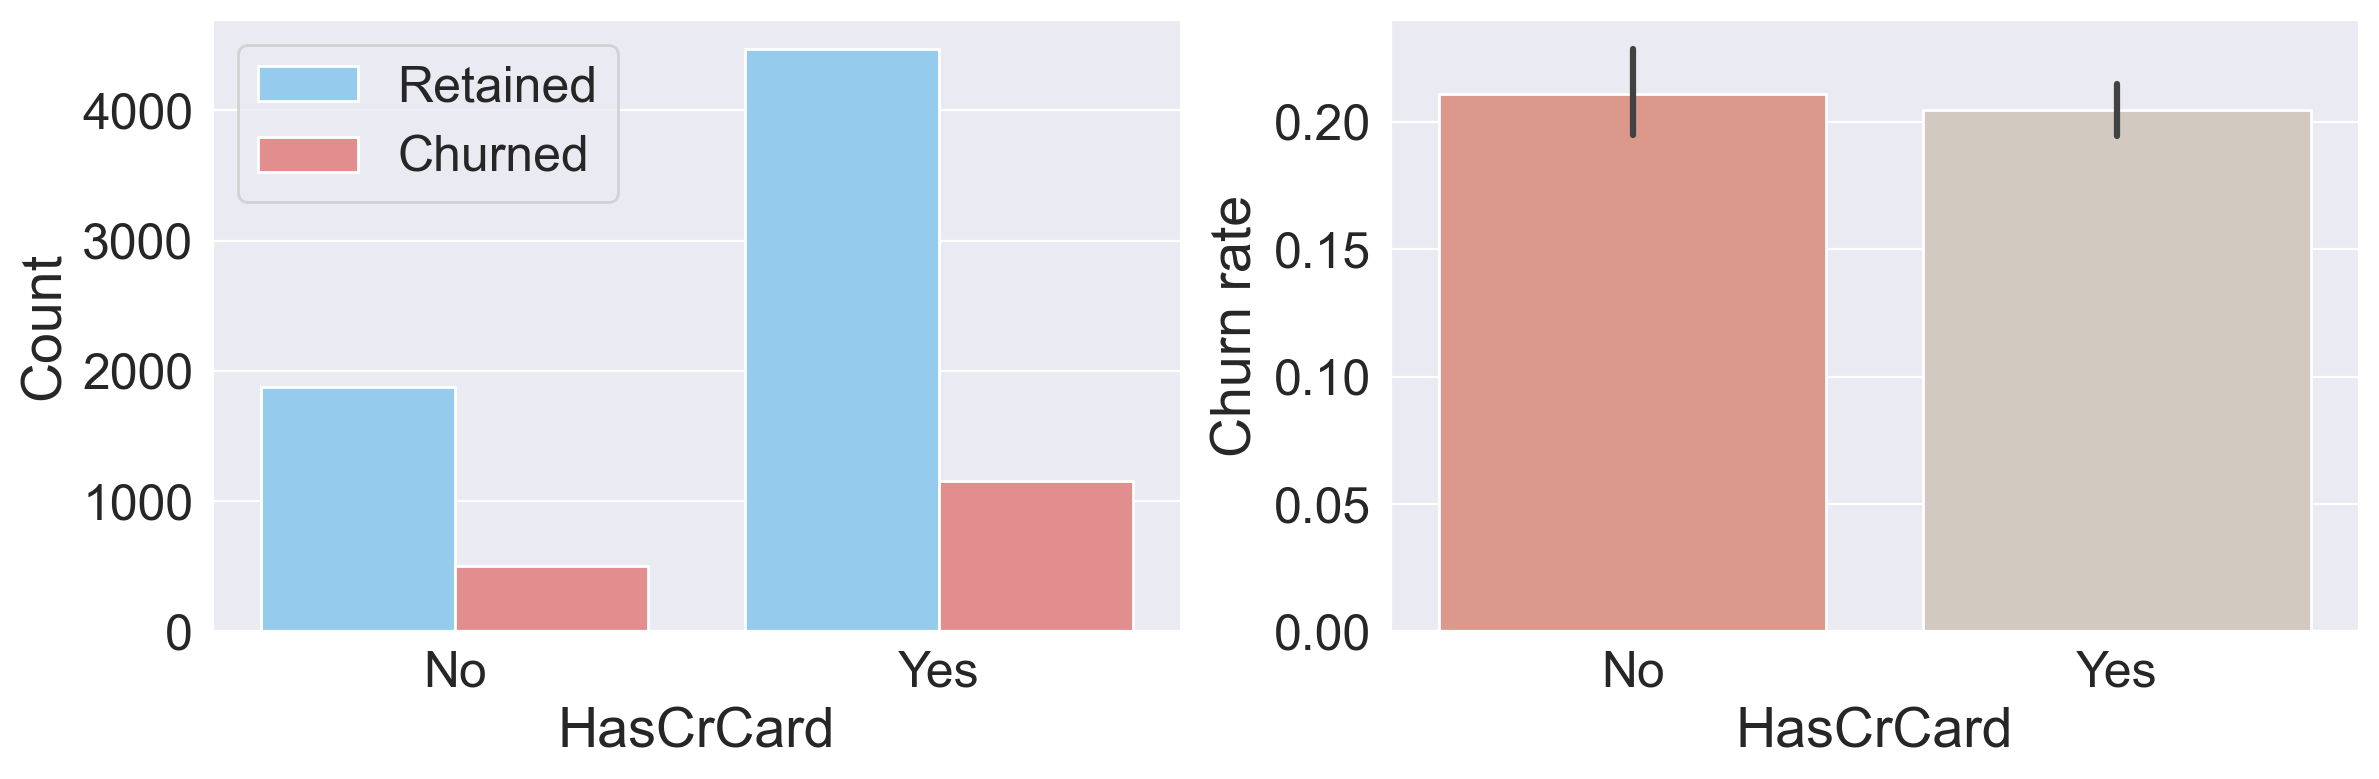

In [87]:
plot_categorical('HasCrCard')


C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\1514023485.py:12: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(x=feature, y='Exited', data=train_df, palette=colors_cat, ax=ax2)
C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\1514023485.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['No', 'Yes'])
C:\Users\Jawad Z\AppData\Local\Temp\ipykernel_1628\1514023485.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['No', 'Yes'])


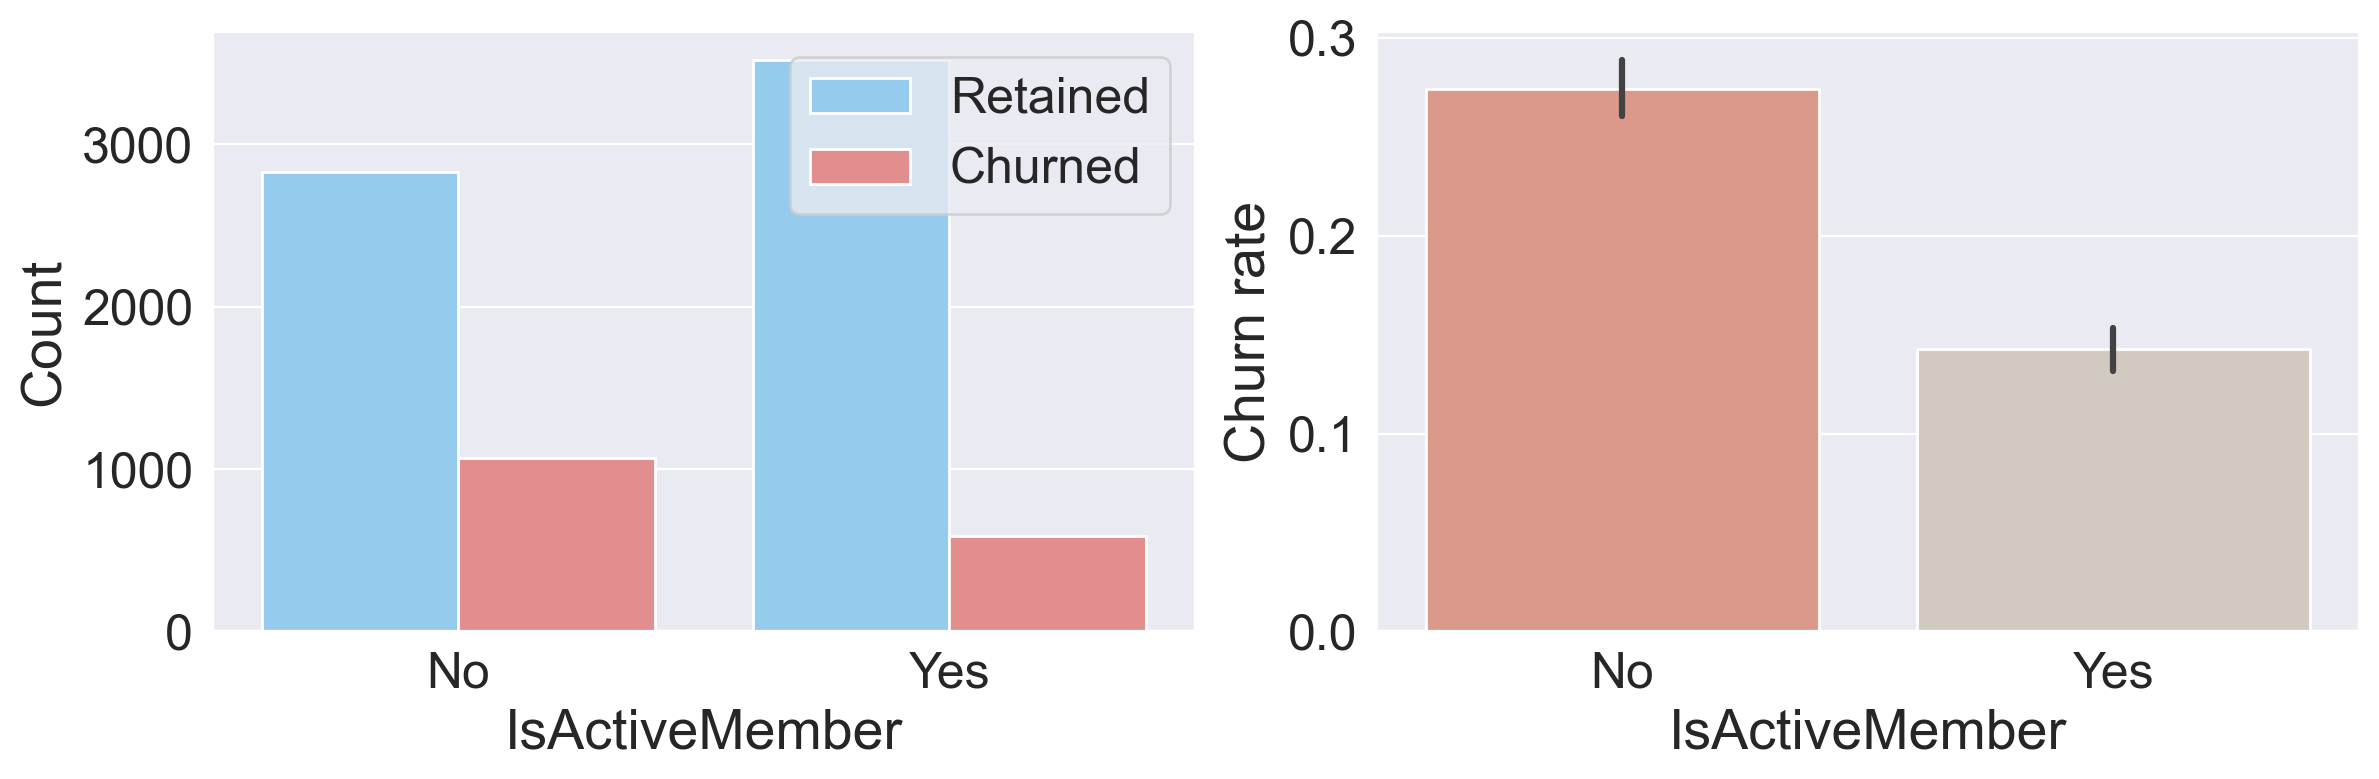

In [88]:
plot_categorical('IsActiveMember')


In [89]:
chi2_array, p_array = [], []
for column in categorical:

    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)


,Variable,Chi-square,p-value
3,NumOfProducts,1228.360333,5.151086e-266
0,Geography,219.443459,2.230788e-48
5,IsActiveMember,209.625829,1.657676e-47
1,Gender,94.075297,3.037466e-22
2,Tenure,12.168438,2.739417e-01
4,HasCrCard,0.345592,5.566188e-01


# still working on machine learning

In [90]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

print('✔️ Features Dropped!')

✔️ Features Dropped!


In [91]:
# Encoding Categorical Features¶


In [92]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

print('✔️ Features Encoded!')

✔️ Features Encoded!


In [93]:
# Scaling

In [94]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print('✔️ Features Scaled!')

✔️ Features Scaled!


In [95]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

print('✔️ Sets Created!')

✔️ Sets Created!


In [96]:
y_train.value_counts()


0    6347
1    1653
Name: Exited, dtype: int64

In [97]:
over = SMOTE(sampling_strategy='auto')
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

0    6347
1    6347
Name: Exited, dtype: int64

In [101]:

    
    
    
import time

start_time = time.time()
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression())]

cv_base_mean, cv_std = [], []
for clf in clf_list:

    cv = cross_val_score(estimator=clf[1],
                         X=X_train,
                         y=y_train,
#                          scoring=scoring_metric,
                         cv=5,
                         n_jobs=-1)

    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

print('Baseline Models (Recall):')

for i in range(len(clf_list)):
    print('   {}: {}'.format(clf_list[i][0], np.round(cv_base_mean[i], 2)))

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Baseline Models (Recall):
   Gaussian Naive Bayes: 0.73
   Logistic Regression: 0.72
Execution time: 0.13866138458251953 seconds


In [99]:
# LR

C:\Users\Jawad Z\anaconda3\anaconda_latest\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Jawad Z\anaconda3\anaconda_latest\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jawad Z\anaconda3\anaconda_latest\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Jaw


 Logistic Regression
-------------------------------
   Best Score (recall): 0.752
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear
Execution time: 1.3352184295654297 seconds


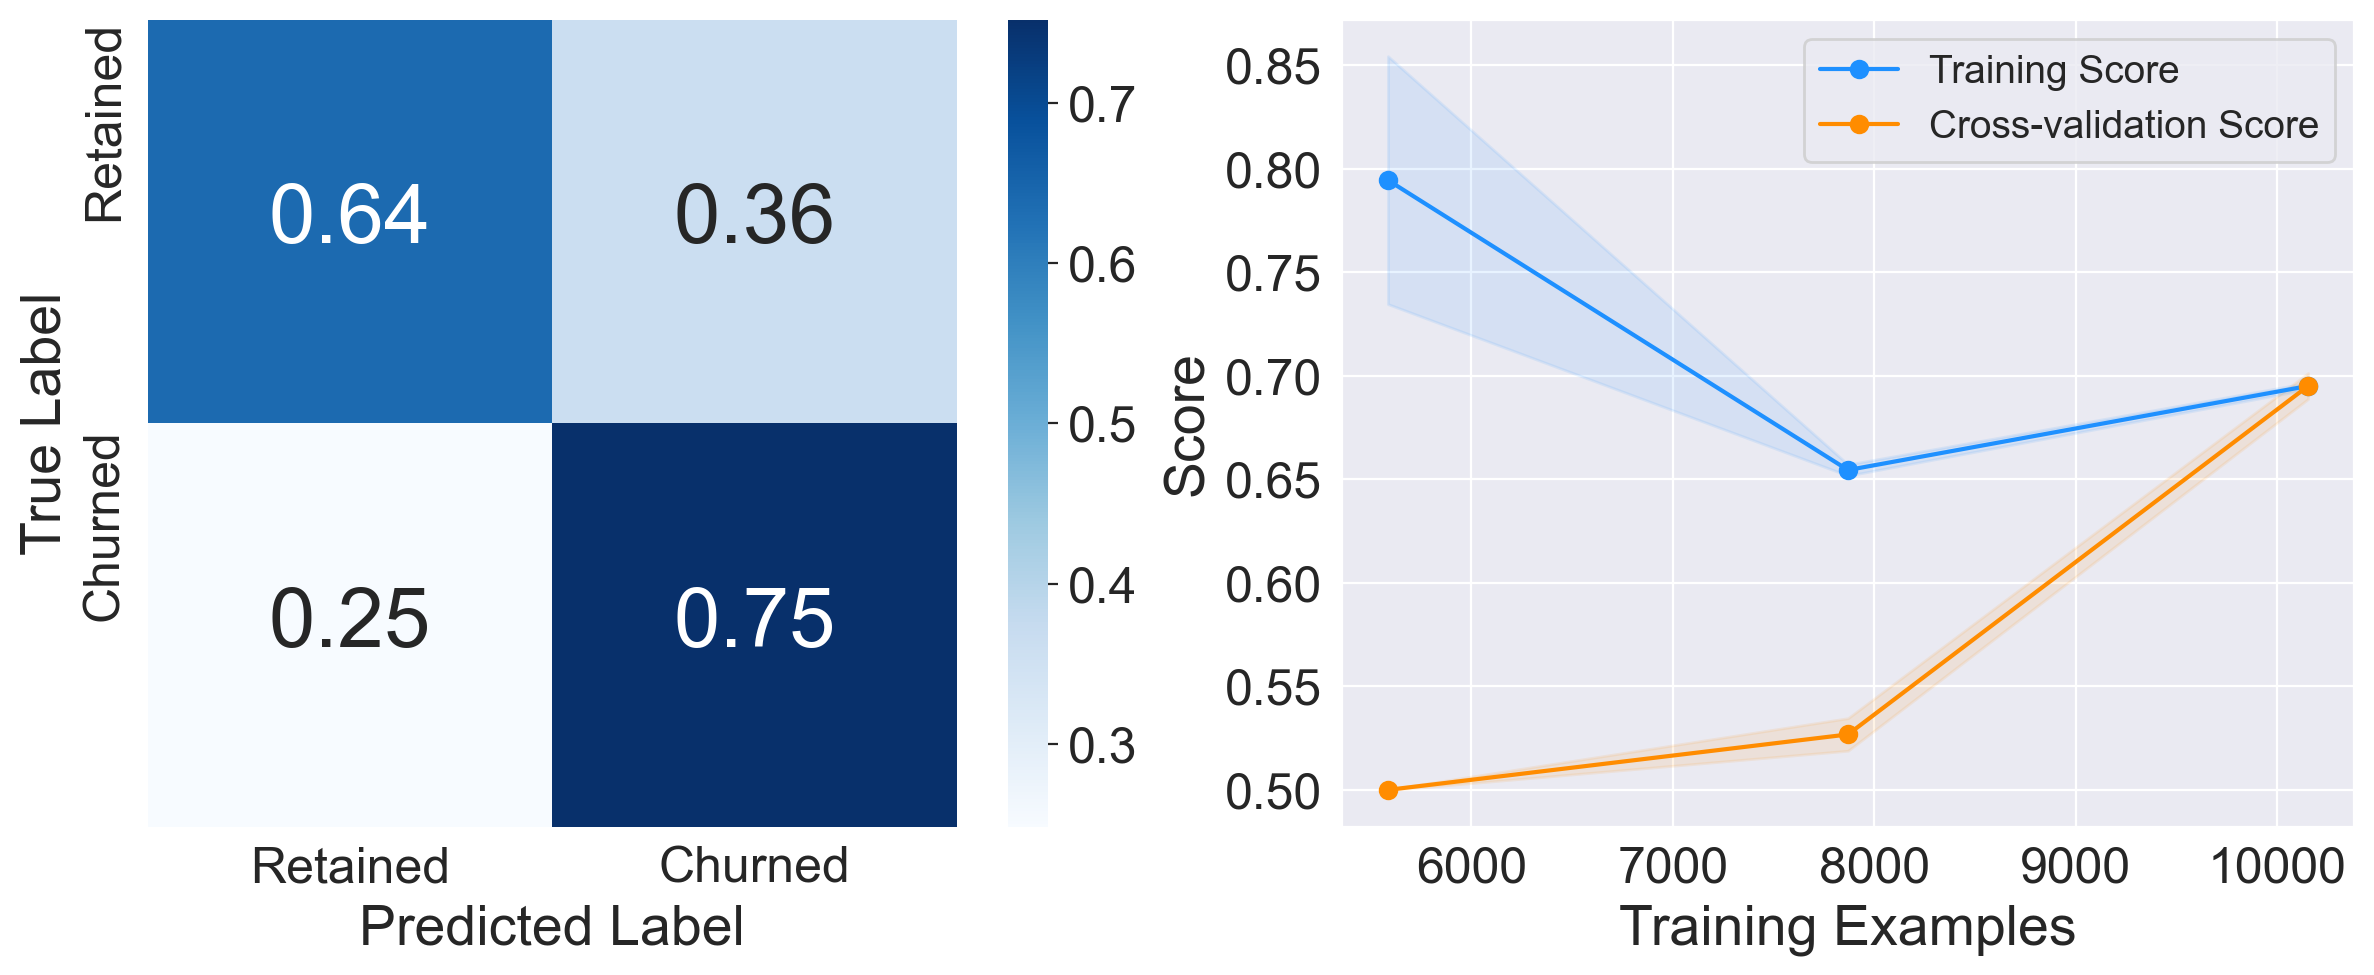

In [102]:






import time

start_time = time.time()
lr = LogisticRegression()

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")



 Random Forest
-------------------------------
   Best Score (recall): 0.777
   Best Parameters: 
      bootstrap: False
      criterion: gini
      max_depth: 6
      max_features: auto
      min_samples_leaf: 2
      min_samples_split: 5
      n_estimators: 100
Execution time: 87.78573083877563 seconds


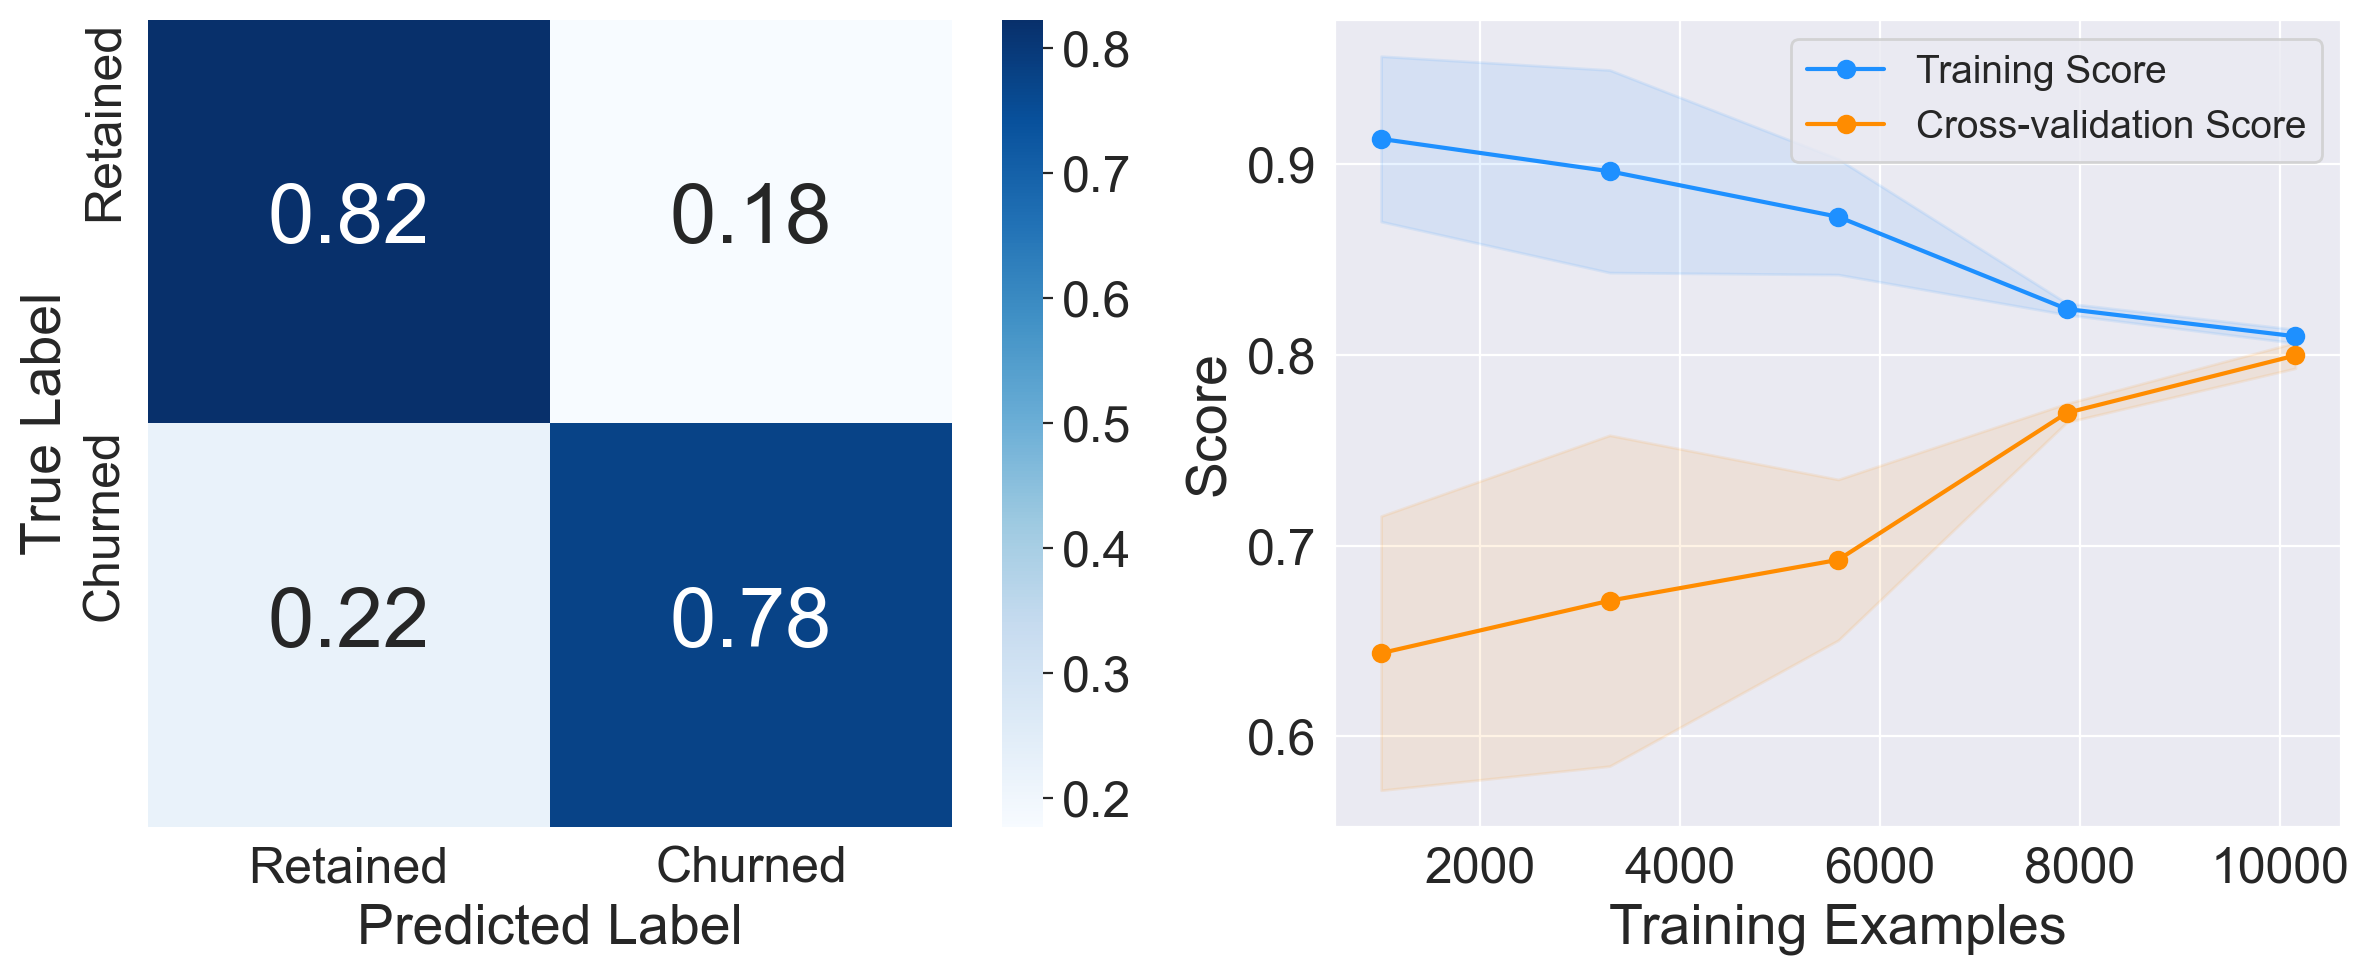

In [103]:



import time

start_time = time.time()
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")




 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.773
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: auto
      min_samples_leaf: 3
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2
Execution time: 131.06851482391357 seconds


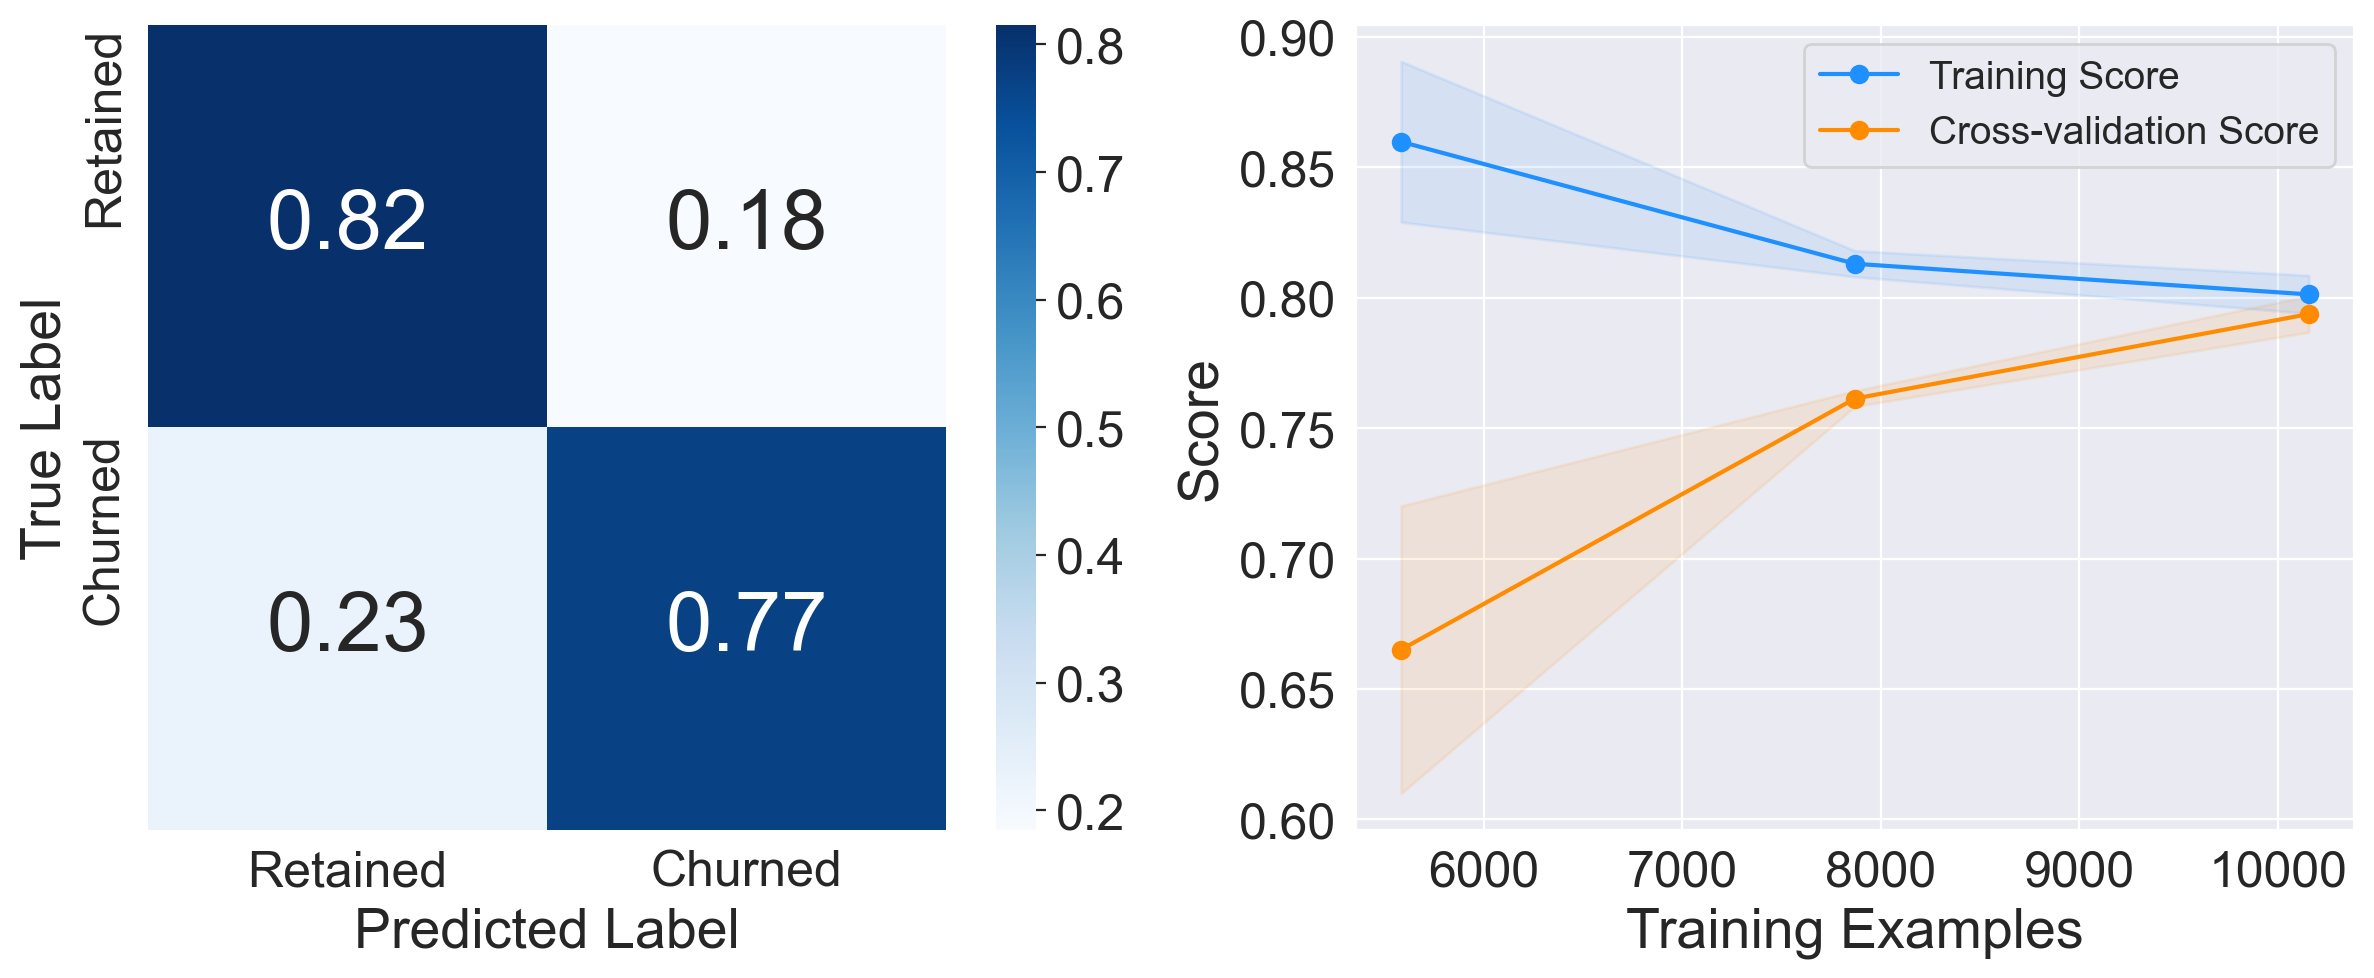

In [104]:



start_time = time.time()

gbc = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],  # default=3
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_gbc_clf = gbc_clf.fit(X_train, y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC')

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

In [105]:

start_time = time.time()

best_gbc_clf.best_estimator_.n_estimators_

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 0.0 seconds



 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.788
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 0.1
      learning_rate: 0.01
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.5
Execution time: 56.477726221084595 seconds


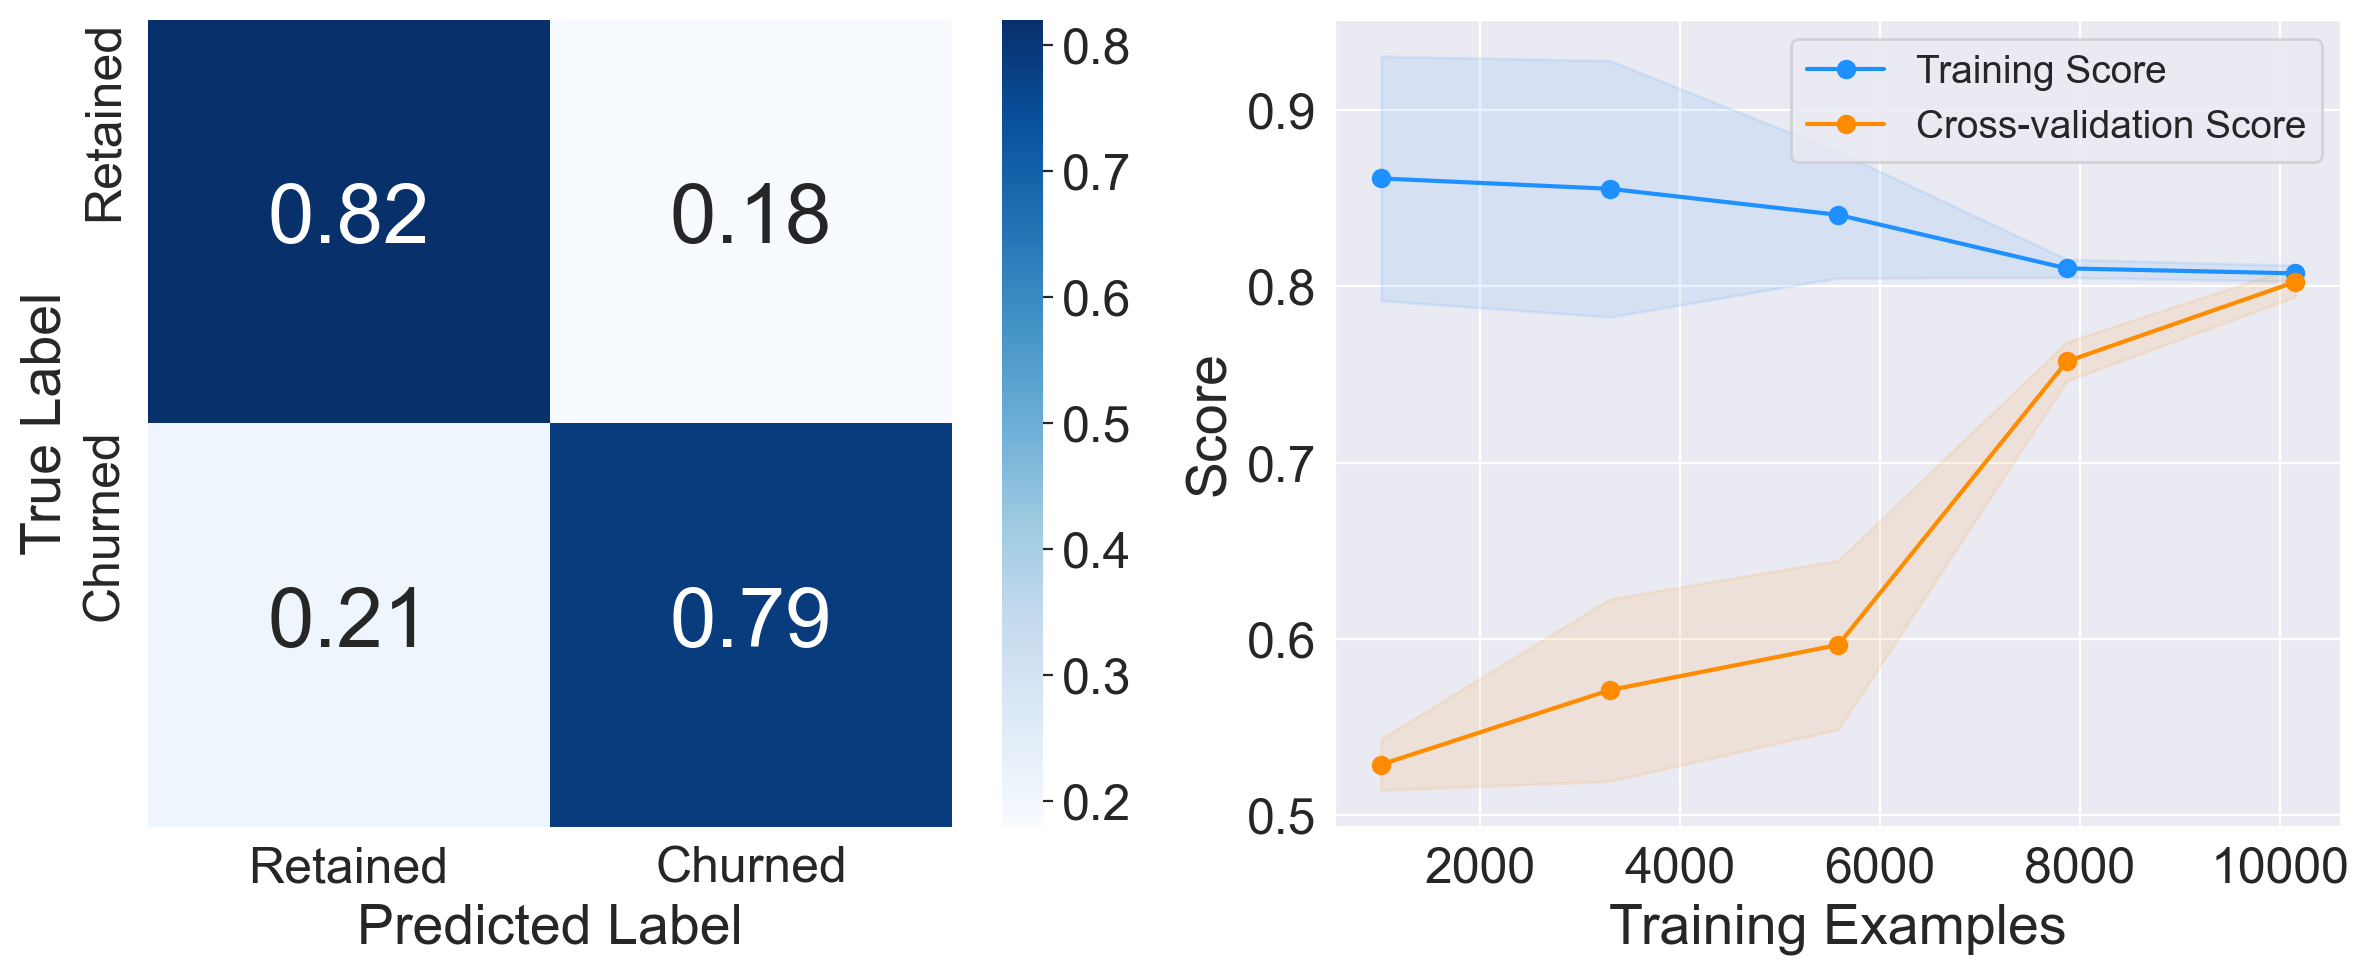

In [106]:



import time

start_time = time.time()
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  # default=6
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 6347, number of negative: 6347
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 12694, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

 LGBMClassifier
-------------------------------
   Best Score (recall): 0.781
   Best Parameters: 
      feature_fraction: 0.5
      learning_rate: 0.01
      max_depth: 5
      min_child_samples: 5
      n_estimators: 200
      num_leaves: 10
     

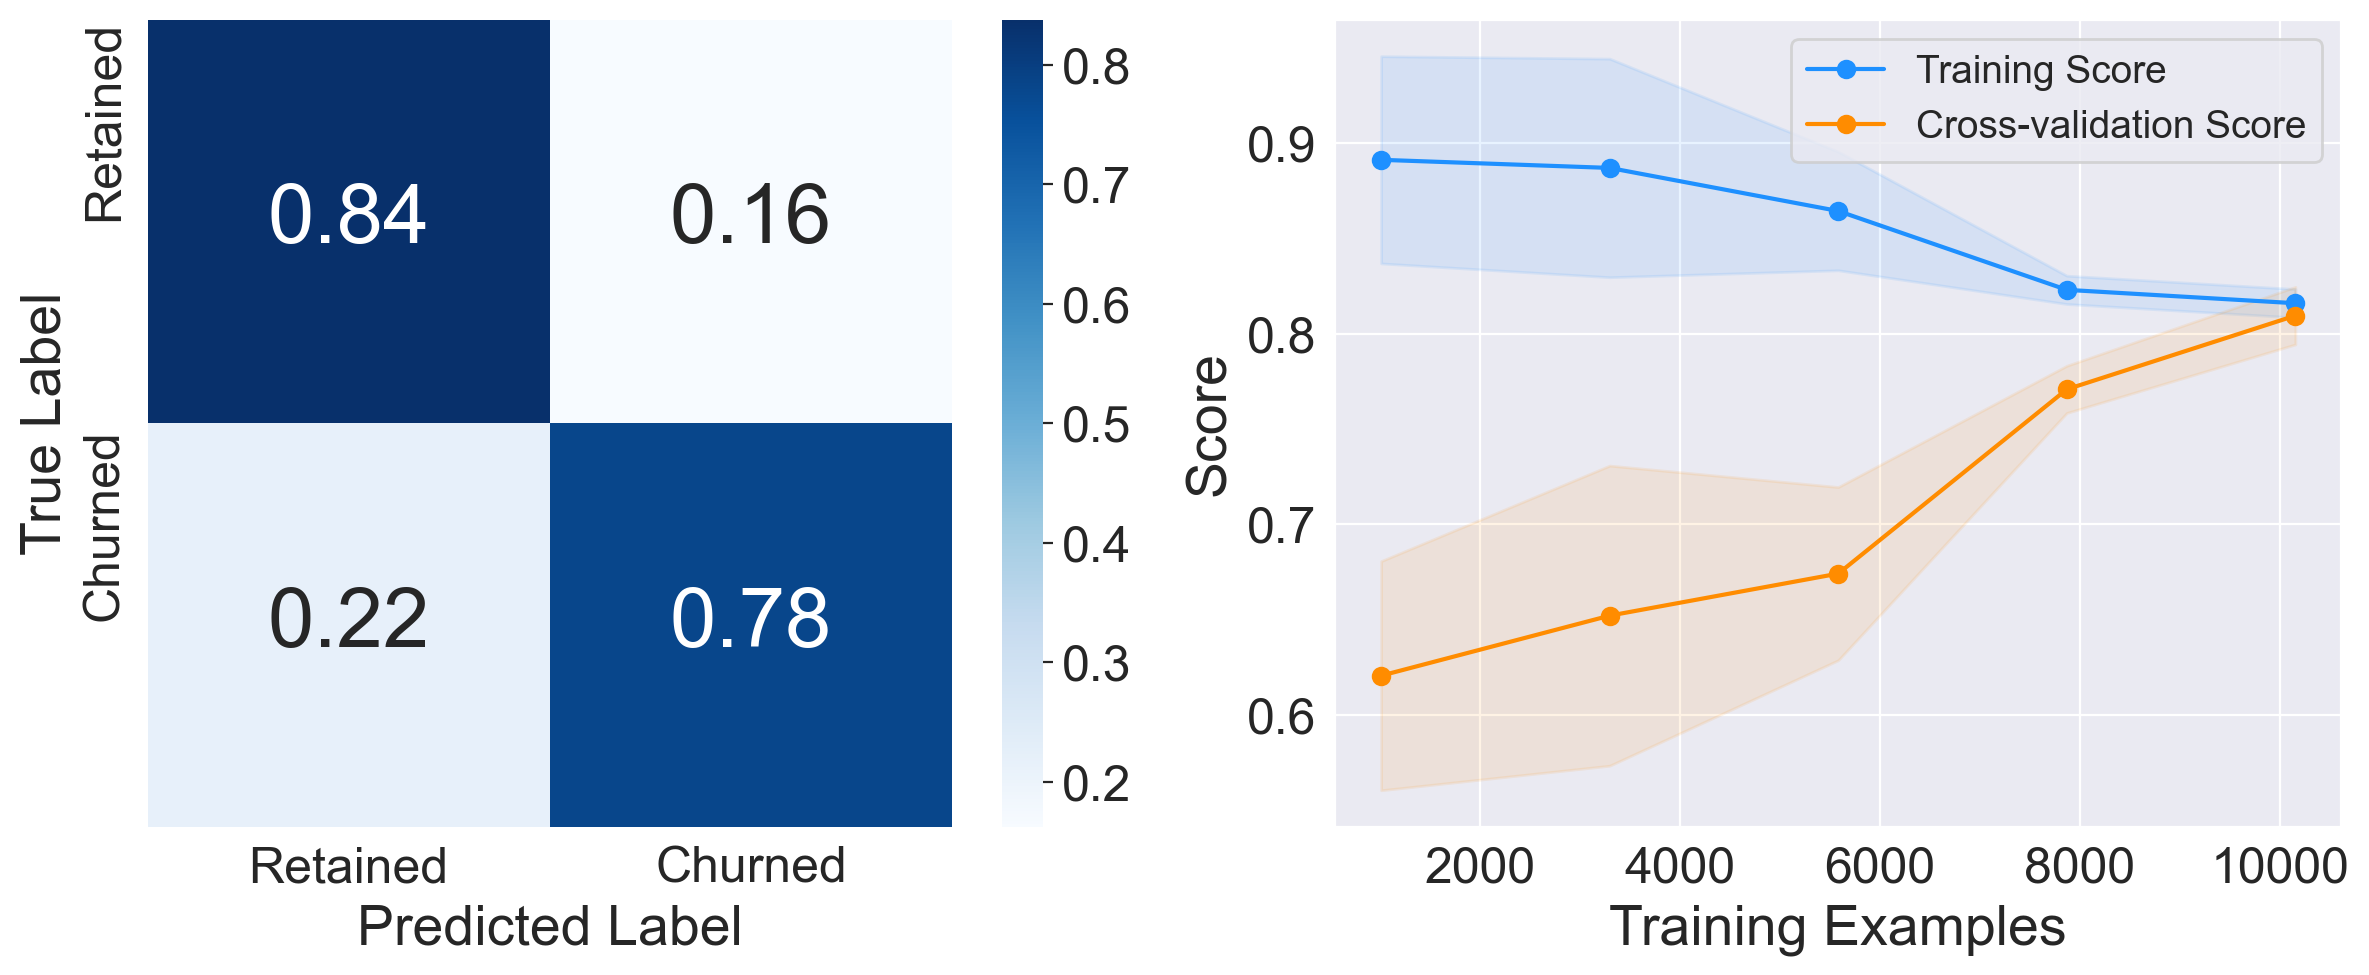

In [107]:




start_time = time.time()

lgbmc = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc_clf = lgbmc_clf.fit(X_train, y_train)
clf_performance(best_lgbmc_clf, 'LGBMClassifier', 'LGBMC')
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")



# we use this code to create results

In [303]:
# estimators = [('LR', best_lr_clf.best_estimator_),
#               ('SCV', best_svc_clf.best_estimator_),
#               ('RF', best_rf_clf.best_estimator_),
#               ('GBC', best_gbc_clf.best_estimator_),
#               ('XGB', best_xgb_clf.best_estimator_),
#               ('LGBMC', best_lgbmc_clf.best_estimator_)]

# tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
#                                      voting='soft',
#                                      n_jobs=-1)
# estimators.append(('SoftV', tuned_voting_soft))

# y_pred_pp = cross_val_predict(tuned_voting_soft,
#                               X_train,
#                               y_train,
#                               cv=5,
#                               method='predict_proba')[:, 1]
# y_pred = y_pred_pp.round()

# cm = confusion_matrix(y_train, y_pred, normalize='true')
# fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
# comparison_dict['SVot'] = [
#     accuracy_score(y_train, y_pred),
#     precision_score(y_train, y_pred),
#     recall_score(y_train, y_pred),
#     roc_auc_score(y_train, y_pred_pp), fpr, tpr
# ]

# print('Soft Voting\n-----------------')
# print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# plot_conf_mx(cm, ax1)
# plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

In [108]:




import time

start_time = time.time()

comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Execution time: 0.08126354217529297 seconds


In [305]:
pip install tensorflow

# DEEP Learning

# ANN

Epoch 1/20
200/200 [==============================] - 1s 3ms/step - loss: 0.4542 - accuracy: 0.8031 - val_loss: 0.4074 - val_accuracy: 0.8281
Epoch 2/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3950 - accuracy: 0.8395 - val_loss: 0.3770 - val_accuracy: 0.8494
Epoch 3/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3672 - accuracy: 0.8508 - val_loss: 0.3607 - val_accuracy: 0.8519
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3548 - accuracy: 0.8555 - val_loss: 0.3560 - val_accuracy: 0.8487
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3493 - accuracy: 0.8569 - val_loss: 0.3519 - val_accuracy: 0.8462
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3457 - accuracy: 0.8564 - val_loss: 0.3612 - val_accuracy: 0.8537
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.3419 - accuracy: 0.8589 - val_loss: 0.3482 - val_accuracy: 0.8494
Epoch 

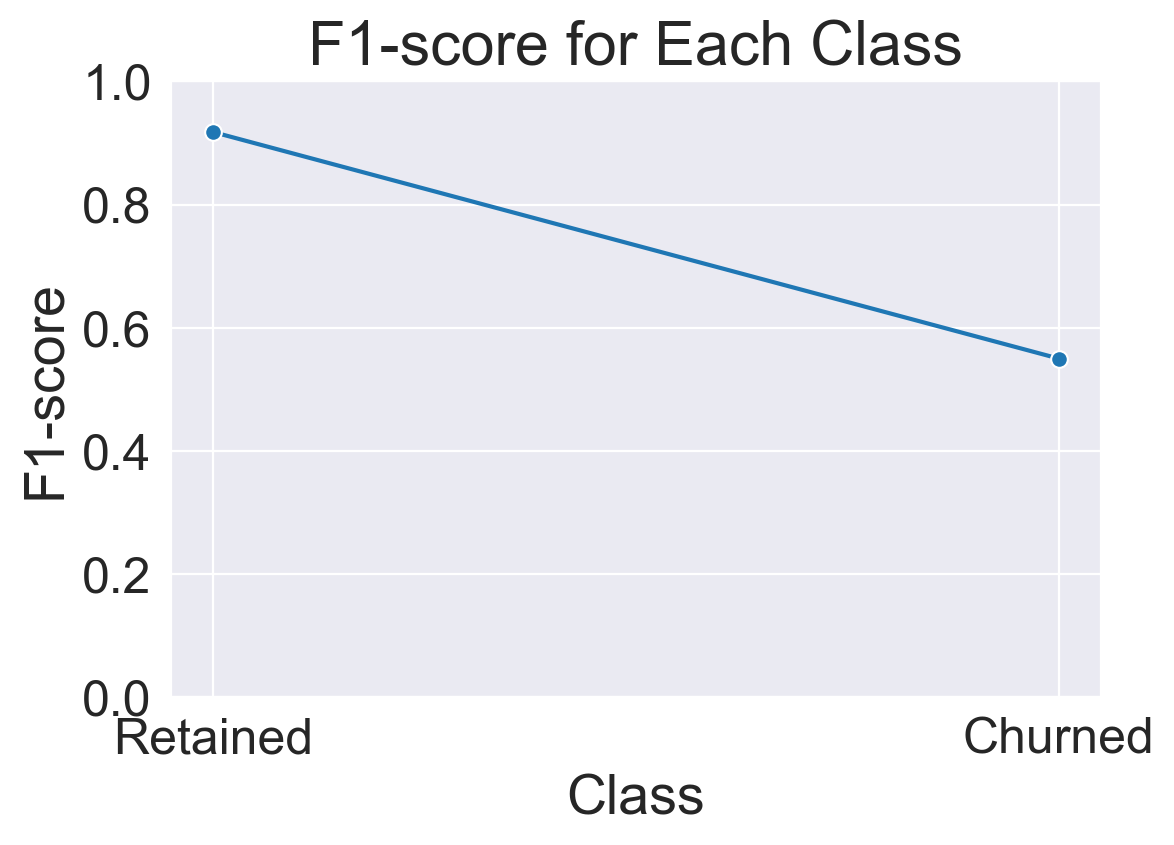

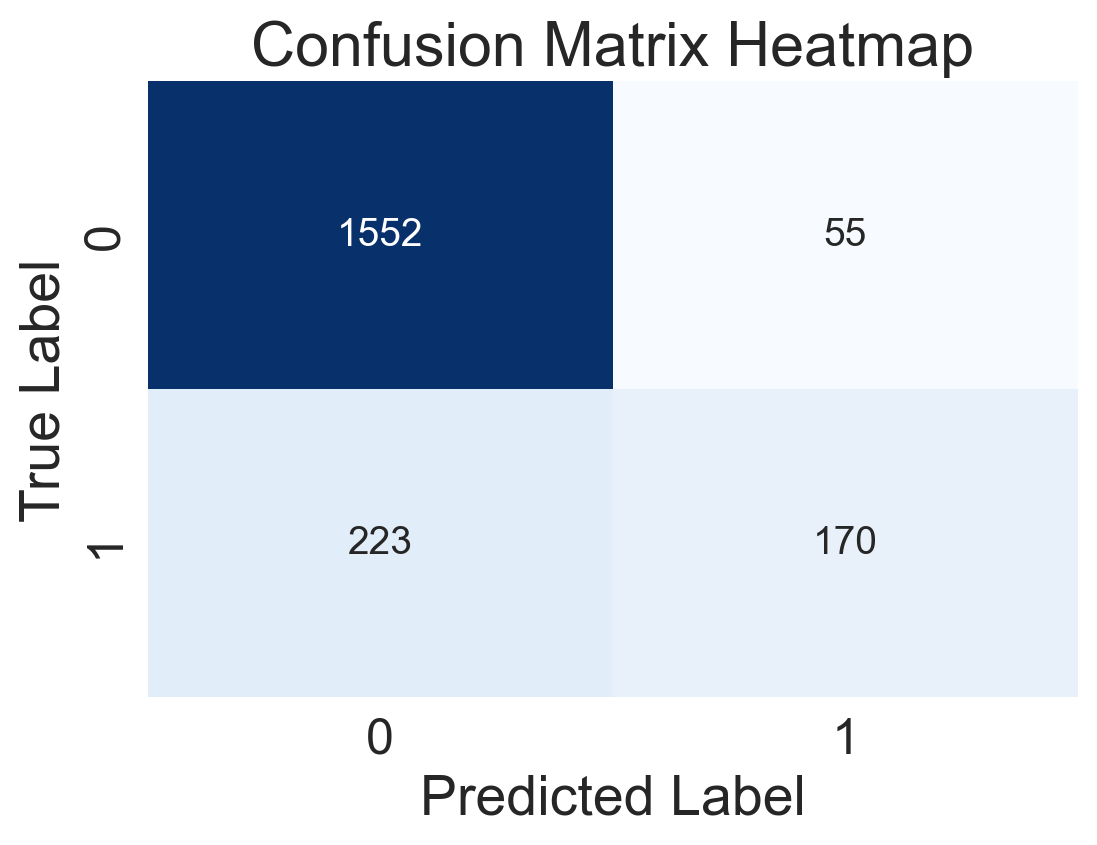

Execution time: 20.54728865623474 seconds


In [109]:


import time

start_time = time.time()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv('Churn_Modelling.csv')

# Data Preprocessing
# Drop unnecessary columns (e.g., RowNumber, CustomerId, Surname)
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col])

# Separate features (X) and target (y)
X = data.drop(columns=['Exited'])
y = data['Exited']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the deep learning model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()  # Thresholding at 0.5 to get binary classes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
classification_rep = classification_report(y_test, y_pred_classes, output_dict=True)

# Print the evaluation results
print(f"Test Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

# Create a line chart for the F1-score for each class
f1_scores = [classification_rep[str(i)]['f1-score'] for i in range(2)]
plt.figure(figsize=(6, 4))
sns.lineplot(x=['Retained', 'Churned'], y=f1_scores, marker='o')
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score for Each Class')
plt.ylim(0, 1)
plt.show()

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()



end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")



# LSTM

Epoch 1/20
200/200 [==============================] - 2s 4ms/step - loss: 0.4920 - accuracy: 0.7947 - val_loss: 0.4204 - val_accuracy: 0.8213
Epoch 2/20
200/200 [==============================] - 1s 3ms/step - loss: 0.4119 - accuracy: 0.8288 - val_loss: 0.3835 - val_accuracy: 0.8512
Epoch 3/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3716 - accuracy: 0.8525 - val_loss: 0.3598 - val_accuracy: 0.8519
Epoch 4/20
200/200 [==============================] - 1s 3ms/step - loss: 0.3549 - accuracy: 0.8558 - val_loss: 0.3510 - val_accuracy: 0.8506
Epoch 5/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3489 - accuracy: 0.8567 - val_loss: 0.3472 - val_accuracy: 0.8550
Epoch 6/20
200/200 [==============================] - 1s 3ms/step - loss: 0.3450 - accuracy: 0.8597 - val_loss: 0.3481 - val_accuracy: 0.8550
Epoch 7/20
200/200 [==============================] - 1s 4ms/step - loss: 0.3417 - accuracy: 0.8567 - val_loss: 0.3457 - val_accuracy: 0.8500
Epoch 

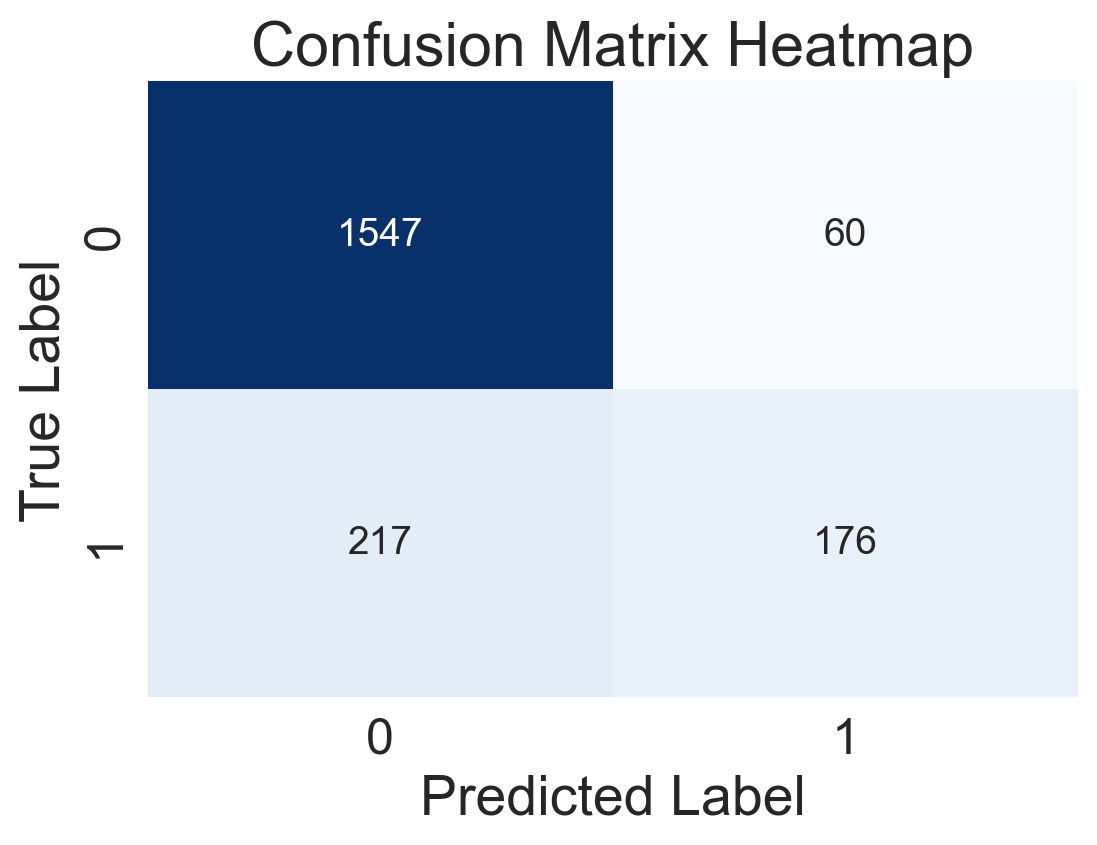

Execution time: 15.790343284606934 seconds


In [110]:


import time

start_time = time.time()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv('Churn_Modelling.csv')

# Data Preprocessing
# Drop unnecessary columns (e.g., RowNumber, CustomerId, Surname)
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col])

# Separate features (X) and target (y)
X = data.drop(columns=['Exited'])
y = data['Exited']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data to fit the LSTM input format
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(1, X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()  # Thresholding at 0.5 to get binary classes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
classification_rep = classification_report(y_test, y_pred_classes)

print(f"Test Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()



end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


# RNN

In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv('Churn_Modelling.csv')

# Data Preprocessing
# Drop unnecessary columns (e.g., RowNumber, CustomerId, Surname)
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col])

# Separate features (X) and target (y)
X = data.drop(columns=['Exited'])
y = data['Exited']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data to fit the RNN input format
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()  # Thresholding at 0.5 to get binary classes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
classification_rep = classification_report(y_test, y_pred_classes)

print(f"Test Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


import time

start_time = time.time()
import time

start_time = time.time()

# Your code here

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")



Epoch 1/20
200/200 [==============================] - 3s 8ms/step - loss: 0.5232 - accuracy: 0.7934 - val_loss: 0.5009 - val_accuracy: 0.7987
Epoch 2/20
200/200 [==============================] - 1s 6ms/step - loss: 0.4946 - accuracy: 0.7942 - val_loss: 0.4796 - val_accuracy: 0.8044
Epoch 3/20
200/200 [==============================] - 1s 6ms/step - loss: 0.4593 - accuracy: 0.8120 - val_loss: 0.4777 - val_accuracy: 0.8213
Epoch 4/20
200/200 [==============================] - 2s 8ms/step - loss: 0.4487 - accuracy: 0.8167 - val_loss: 0.4388 - val_accuracy: 0.8225
Epoch 5/20
200/200 [==============================] - 1s 7ms/step - loss: 0.4405 - accuracy: 0.8198 - val_loss: 0.4370 - val_accuracy: 0.8194
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.4381 - accuracy: 0.8213 - val_loss: 0.4307 - val_accuracy: 0.8238
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 0.4330 - accuracy: 0.8241 - val_loss: 0.4268 - val_accuracy: 0.8269
Epoch 

Epoch 1/20
200/200 [==============================] - 3s 7ms/step - loss: 0.5251 - accuracy: 0.7920 - val_loss: 0.5034 - val_accuracy: 0.7987
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4936 - accuracy: 0.7942 - val_loss: 0.4649 - val_accuracy: 0.8056
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4647 - accuracy: 0.8072 - val_loss: 0.4498 - val_accuracy: 0.8206
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4532 - accuracy: 0.8161 - val_loss: 0.4416 - val_accuracy: 0.8219
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4447 - accuracy: 0.8178 - val_loss: 0.4450 - val_accuracy: 0.8231
Epoch 6/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4381 - accuracy: 0.8217 - val_loss: 0.4377 - val_accuracy: 0.8194
Epoch 7/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4337 - accuracy: 0.8219 - val_loss: 0.4349 - val_accuracy: 0.8238
Epoch 

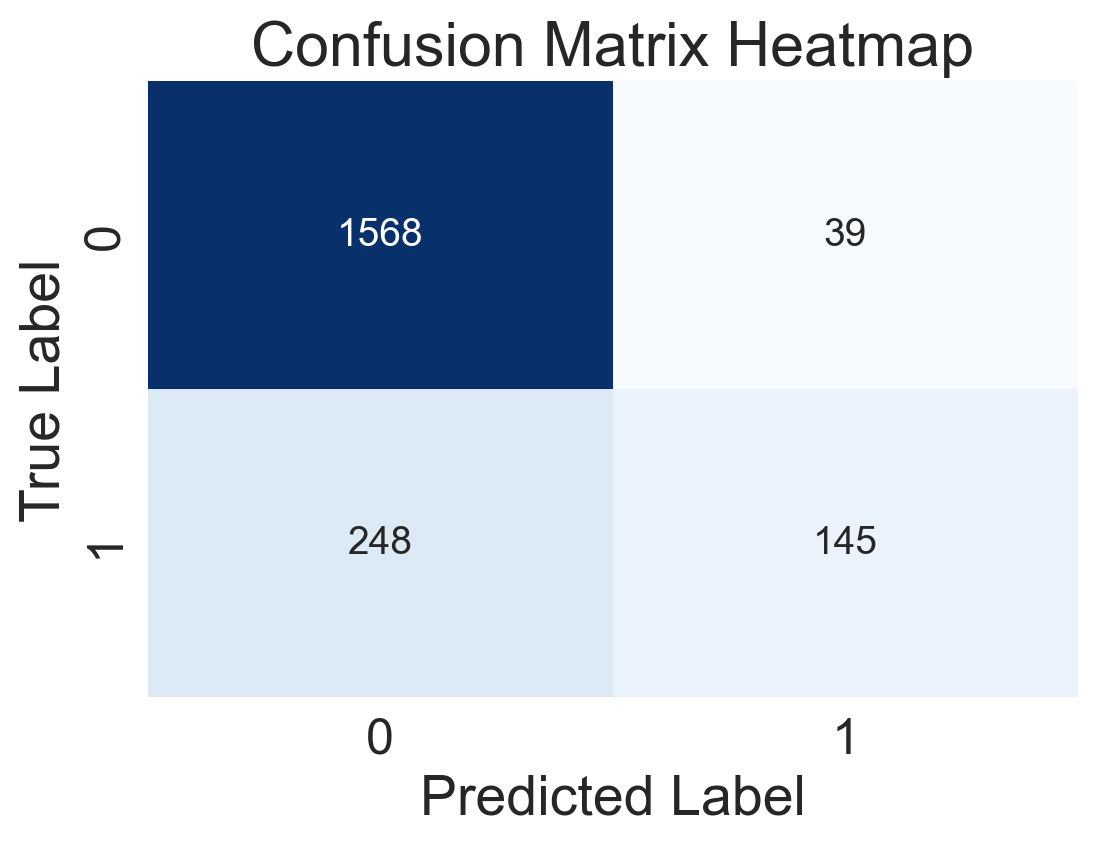

Execution time: 24.22148084640503 seconds


In [112]:



import time

start_time = time.time()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv('Churn_Modelling.csv')

# Data Preprocessing
# Drop unnecessary columns (e.g., RowNumber, CustomerId, Surname)
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

# Convert categorical variables to numerical using Label Encoding
label_encoder = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = label_encoder.fit_transform(data[col])

# Separate features (X) and target (y)
X = data.drop(columns=['Exited'])
y = data['Exited']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data to fit the RNN input format
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Make predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()  # Thresholding at 0.5 to get binary classes

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
classification_rep = classification_report(y_test, y_pred_classes)

print(f"Test Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


# Graphical comparison of ML graphs

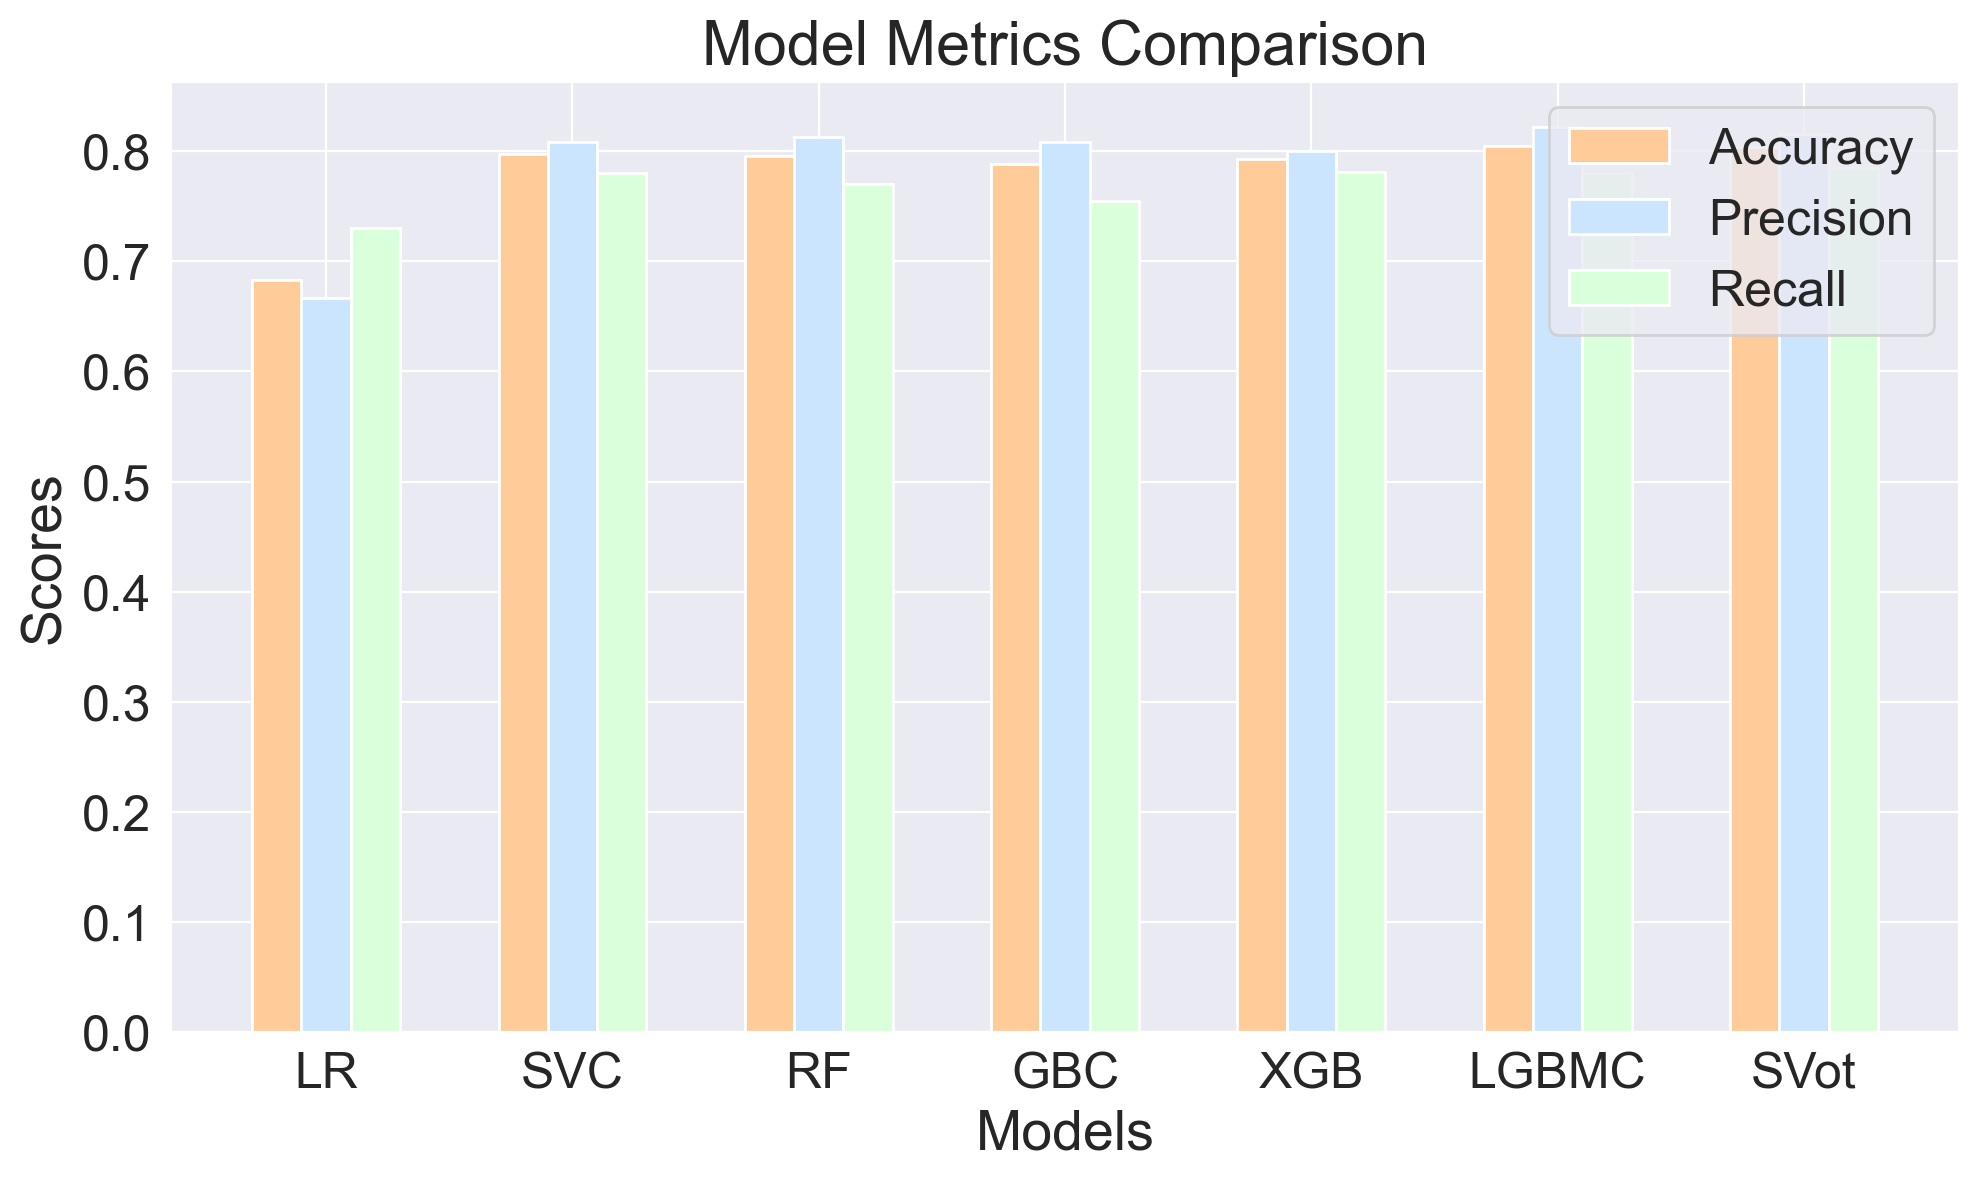

In [310]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = ['LR', 'SVC', 'RF', 'GBC', 'XGB', 'LGBMC', 'SVot']
accuracy = [0.683, 0.797, 0.796, 0.788, 0.793, 0.805, 0.804]
precision = [0.667, 0.808, 0.813, 0.808, 0.800, 0.822, 0.816]
recall = [0.730, 0.780, 0.770, 0.755, 0.781, 0.780, 0.785]

x = np.arange(len(models))  # the label locations

# Custom light colors for each metric
color_accuracy = '#FFCC99'
color_precision = '#CCE5FF'
color_recall = '#D9FFDB'

# Plotting the bar chart with custom light colors for each metric
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, accuracy, width=0.2, label='Accuracy', color=color_accuracy)
plt.bar(x, precision, width=0.2, label='Precision', color=color_precision)
plt.bar(x + 0.2, recall, width=0.2, label='Recall', color=color_recall)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Metrics Comparison')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()


# Gaphical Comparison Of Deep Learning Algorithem

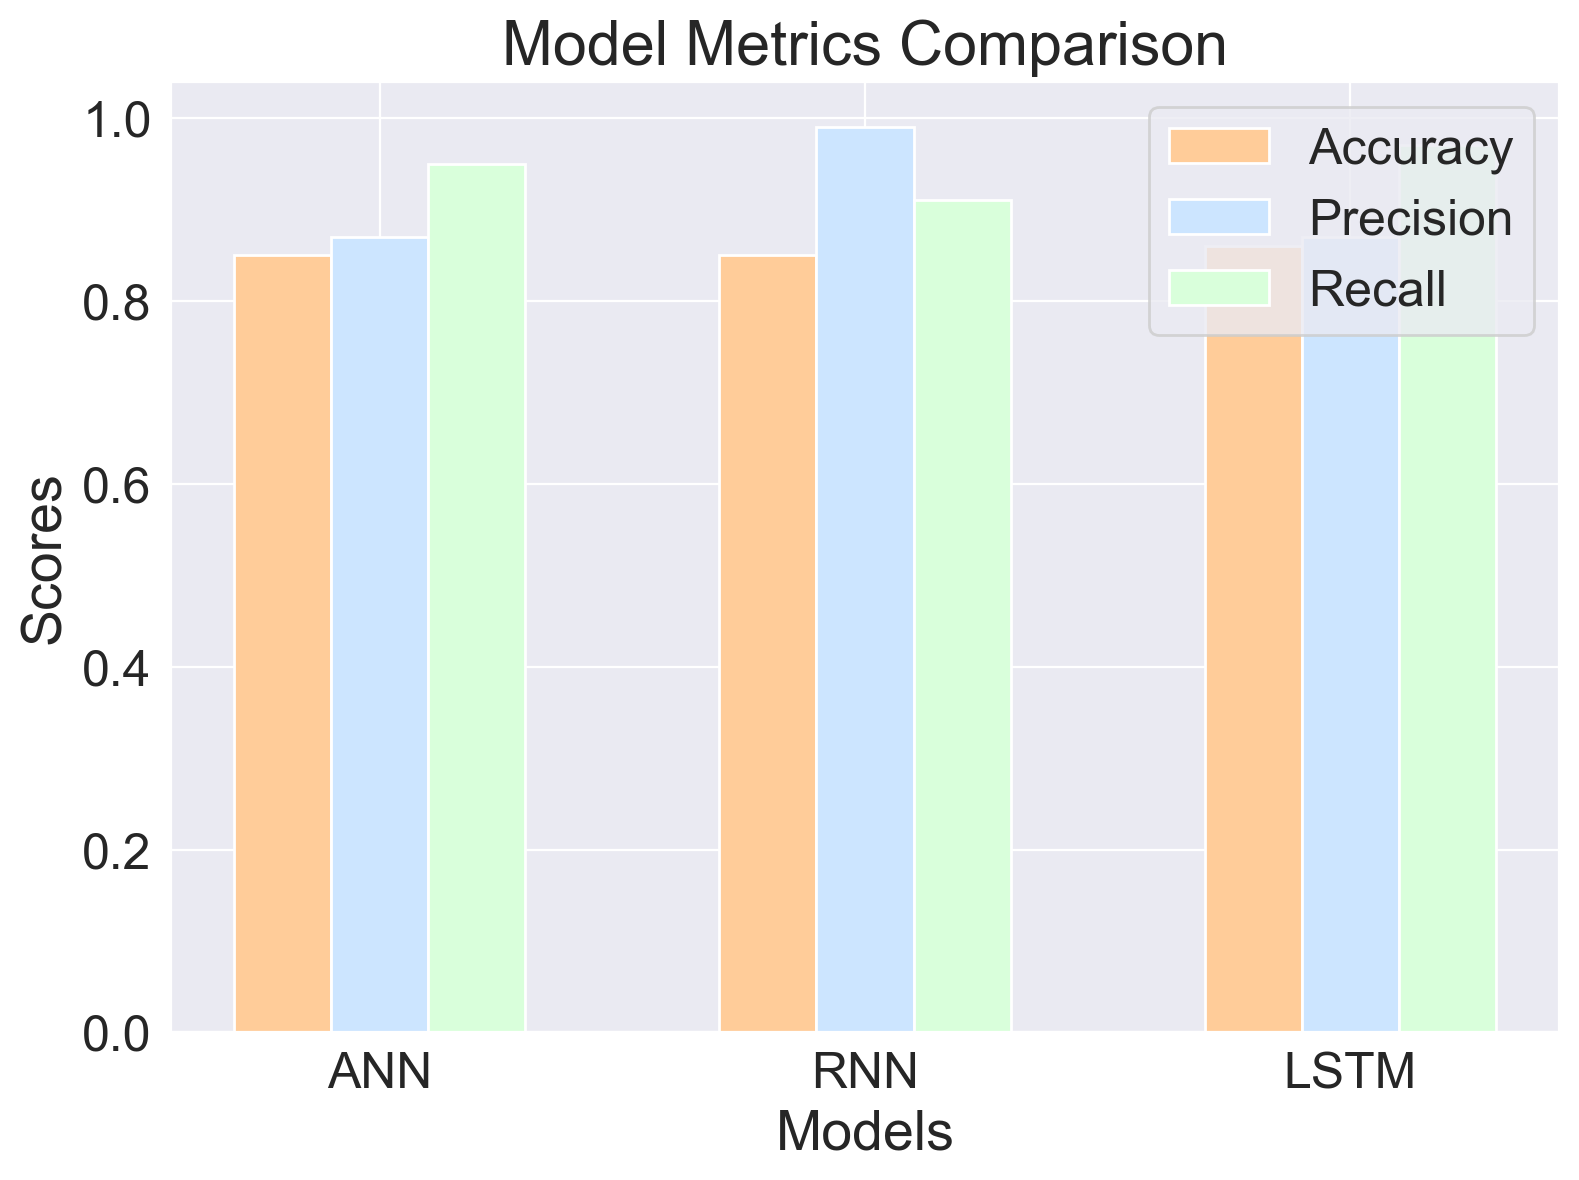

In [311]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = ['ANN', 'RNN', 'LSTM']
accuracy = [0.85, 0.85, 0.86]
precision = [0.87, 0.99, 0.87]
recall = [0.95, 0.91, 0.97]

x = np.arange(len(models))  # the label locations

# Custom light colors for each metric
color_accuracy = '#FFCC99'
color_precision = '#CCE5FF'
color_recall = '#D9FFDB'

# Plotting the bar chart with custom light colors for each metric
plt.figure(figsize=(8, 6))
bar_width = 0.2

plt.bar(x - bar_width, accuracy, width=bar_width, label='Accuracy', color=color_accuracy)
plt.bar(x, precision, width=bar_width, label='Precision', color=color_precision)
plt.bar(x + bar_width, recall, width=bar_width, label='Recall', color=color_recall)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Metrics Comparison')
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()
